
# Exoplanet Classification Project 

Outline of this notebook


1. [Introduction](#introduction)
2. [Dataset](#dataset)
3. [Data Exploration](#data-exploration)
    3.1 Initial Columns Cleaning
4. [Data Preprocessing](#data-preprocessing)
5. [Model Building](#model-building)
6. [Model Evaluation](#model-evaluation)
7. [Conclusion](#conclusion)
8. [References](#references)

![GIFurl](https://media.giphy.com/media/YP2ka5SH2MzpjZvIXB/giphy-downsized.gif "gif")

------------------------------------------------------------------------------------------------------

<a id='introduction'></a>

## 1. Introduction
In this project, we will explore the classification of exoplanets using various machine learning techniques. Exoplanets are planets that orbit stars outside our solar system. The goal of this project is to build a model that can accurately classify weather a Kepler object is an exoplanet based on their recorded features.

#### Imports

In [202]:
import pandas as pd
import os
import xml.etree.ElementTree as ET, urllib.request, gzip, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #missing values plot


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek

from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import TomekLinks
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
# from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import *
from sklearn.svm import SVC



------------------------------------------------------------------------------------------------------

<a id='dataset'></a>

## 2. Dataset
We will be using the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html), specifically the [Kepler Objects of Interest (KOIs)](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) dataset for this project. This dataset contains information about confirmed exoplanets as well as false positives. It includes features such as orbital period, transit depth, planet radius, and more. The target variable is the exoplanet classification, which can be either "Confirmed", "Candidate" or "False Positive". The dataset is updated regularlly.

A snapshot of the table should be saved near the code, here we will load the csv into a dataframe.

#https://drive.google.com/file/d/1WfxroJ_5XD5NE14ZAM4GvsUWoLgI0k1v/view?usp=share_link

In [59]:
nasa_df = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv', skiprows=144)
nasa_df.set_index('rowid', inplace=True)

In [60]:
print("There are " + str(nasa_df.shape[0]) + " rows in the NASA data")
print("There are " + str(nasa_df.shape[1]) + " columns in the NASA data")

There are 9564 rows in the NASA data
There are 140 columns in the NASA data


As we can see in the raw data there are 9,564 rows and 140 columns.

We'll print a few rows, and information about the columns in order to see which are numeric or categorical.

In [61]:
# Print the shape of the dataset
print(nasa_df.shape)

#print first 5 rows of the dataset
nasa_df.head()

(9564, 140)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [62]:
# Analysing type of data
nasa_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9564 entries, 1 to 9564
Data columns (total 140 columns):
 #    Column              Dtype  
---   ------              -----  
 0    kepid               int64  
 1    kepoi_name          object 
 2    kepler_name         object 
 3    koi_disposition     object 
 4    koi_vet_stat        object 
 5    koi_vet_date        object 
 6    koi_pdisposition    object 
 7    koi_score           float64
 8    koi_fpflag_nt       int64  
 9    koi_fpflag_ss       int64  
 10   koi_fpflag_co       int64  
 11   koi_fpflag_ec       int64  
 12   koi_disp_prov       object 
 13   koi_comment         object 
 14   koi_period          float64
 15   koi_period_err1     float64
 16   koi_period_err2     float64
 17   koi_time0bk         float64
 18   koi_time0bk_err1    float64
 19   koi_time0bk_err2    float64
 20   koi_time0           float64
 21   koi_time0_err1      float64
 22   koi_time0_err2      float64
 23   koi_eccen           float64
 24   ko

------------------------------------------------------------------------------------------------------

# 3. Data Exploration 

3.1. Feature Importance 

3.2. 

3.3. Visualize the distribution of the target variable.

3.4. Explore the relationship between the features and the target variable.

------------------------------------------------------------------------------------------------------

<a id='data-exploration'></a>

# 4. Data Preprocessing
Before we start building our classification model, let's first explore the dataset. We will perform the following steps:

4.1. [Initial Feature Cleaning](#column-cleaning)

    - Rename columns.
    - Create target column.
    - Remove irrelevant columns.
    - Remove error columns.
    - Encode categorical features.

4.2. [Handling Missing Values](#missing-values)

    - Drop columns that have more than 50% missing values.
    - Drop rows that have more than 50% missing values.
    - Impute missing values.

4.3. [PCA Outlier Detection](#outliers)  

4.4. [Data Normalization](#normalization)

4.5. [Check for Correlated Features](#corr)

4.6. [Class Balancing](#balance)

4.7. [Feature Selection after SMOTE](#feature-selection)


<a id='column-cleaning'></a>
## 4.1. Initial Column Cleaning

### 4.1.1. Rename Columns
The column names in the loaded csv is an abbreviation of the full name, here we will load these names and rename the columns with the full feature name.

In [63]:
names = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv',skiprows=3, nrows=140, names=['full'])

names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)

names.drop(columns=['full', 'A', 'AA'], inplace=True)
names.rename(columns={'B':'fullname',
                      'AAA':'currentname'}, inplace=True)
names = names.replace(' ', '', regex=True)

names.head()

C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\377690018.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\377690018.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)


,fullname,currentname
0,KepID,kepid
1,KOIName,kepoi_name
2,KeplerName,kepler_name
3,ExoplanetArchiveDisposition,koi_disposition
4,VettingStatus,koi_vet_stat


In [64]:
renaming = {}
for i, r in names.iterrows():
    renaming[r.currentname] = r.fullname

#rename columns with their full name
nasa_df = nasa_df.rename(columns=renaming)
nasa_df.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec]
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


### 4.1.2. Create Target Column

We have two columns describing the disposition of a KOI:
* **Disposition Using Kepler Data**
  * This column describes whether a KOI [Kepler Object of Interest] is considered a candidate for an exoplanet, or a false positive, or a confirmed exoplanet.
*   **Exoplanet Archive Disposition** 
  * This column is similar to above, but it also incorporates newer peer-reviewed/published information from the Exoplanet Archive.

Since the second column includes a more fine grained disposition we will use it as our target.
We will create our target called '*ExoplanetConfirmed*' in the following manner:
- 0 if disposition is false positive or candidate.*italicized text*
- 1 if disposition is confirmed. 

In [65]:
nasa_df['ExoplanetArchiveDisposition'].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2671
CANDIDATE         2054
Name: ExoplanetArchiveDisposition, dtype: int64

In [66]:
nasa_df['ExoplanetConfirmed'] = nasa_df['ExoplanetArchiveDisposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

nasa_df.head(2)

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec],ExoplanetConfirmed
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.16,0.20,0.17,0.08,0.13,0.31,0.17,0.32,0.16,1
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.48,0.39,0.36,0.49,0.34,0.12,0.73,0.50,0.45,1


### 4.1.3. Remove Irrelevant Columns

After the creation of the target class we can remove the other information we have about the kepler disposition, which includes the following columns:


*   **KepID** : id number of the kepler.
*   **KOIName** : the KOI name.
*   **KeplerName** : kepler name.
*   **ExoplanetArchiveDisposition** : will be removed after processing.
*   **VettingStatus** : "ACTIVE" or "DONE". Active provides the latest information for follow-up observations, and the transition to "DONE" status occurs when all dispositions are finalized and model parameters are updated appropriately.
*   **DateofLastParameterUpdate** : date of when the keplet info was last updated.
*   **DispositionUsingKeplerData** : the disposition described above.
*   **DispositionScore** : A value between 0 and 1 that indicates the confidence in the KOI disposition.
*   **Comment** : A description of the reason why an object's disposition has been given as false positive.
*   **NotTransit-LikeFalsePositiveFlag** : A KOI whose light curve is not consistent with that of a transiting planet.
*   **DispositionProvenance** : Disposition Provenance

It is important to remove these column because they have high correlation with our labels, which would introduce bias to our models.



In [67]:
def drop_columns(df, to_drop):
    print("Data shape before dropping columns : ", df.shape)
    df.drop(columns=to_drop, inplace=True)    
    print("Data shape after dropping columns : ", df.shape)
    
unimportant_columns = ['KepID', 'KOIName', 'KeplerName', 'VettingStatus', 
                       'DateofLastParameterUpdate', 'DispositionUsingKeplerData', 'DispositionScore',
                       'Comment', 'NotTransit-LikeFalsePositiveFlag', 'DispositionProvenance']

print("Dropping unimportant columns from data")
drop_columns(nasa_df, unimportant_columns)

Dropping unimportant columns from data
Data shape before dropping columns :  (9564, 141)
Data shape after dropping columns :  (9564, 131)


### 4.1.4. Remove Error Columns

Some columns are the errors margins of the calculations in other columns. We will remove these error columns

In [68]:
err_colummns = []

# go over cols and get every col with 'Unc.' in it
for c in nasa_df.columns:
    if 'Unc.' in c:
        err_colummns.append(c)
        
print("Dropping error columns from data")
drop_columns(nasa_df, err_colummns)

Dropping error columns from data
Data shape before dropping columns :  (9564, 131)
Data shape after dropping columns :  (9564, 73)


### 4.1.5. Encoding Categorical Data



 Drop all columns that either contain 1 category, or contain too many categories.

In [69]:
def handle_categorical_data(df):
    print("Data shape before handling categorical columns : ", df.shape)
    # These columns either contain only zeros, NaNs, or are irrelevant to our target
    useless_cols = ['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary', 
                    'Quarters', 'Eccentricity', 'LimbDarkeningCoeff.4', 'LimbDarkeningCoeff.3']
    df.drop(useless_cols, axis=1, inplace=True)
    # Create a temporary df that will contain all categorical data
    # We will encode all these columns and merge them back to our main df
    df_categorical = df.select_dtypes(object)
    #encode all categories
    #categorical data
    categorical_cols = ['PlanetaryFitType', 'ParametersProvenance', 'TCEDelivery', 'StellarParameterProvenance'] 
    #import pandas as pd
    df_categorical = pd.get_dummies(df_categorical, columns = categorical_cols) 
    
    # We will merge this with the working DF and delete the categorical columns.
    df.drop(categorical_cols, axis=1, inplace=True)
    df = pd.concat([df, df_categorical], axis=1)

    print("Data shape after handling categorical columns : ", df.shape)
    
    return df


nasa_df = handle_categorical_data(nasa_df)

#remove duplicate columns
nasa_df = nasa_df.loc[:,~nasa_df.columns.duplicated()].copy()

nasa_df.head(2)

Data shape before handling categorical columns :  (9564, 73)
Data shape after handling categorical columns :  (9564, 76)


,ExoplanetArchiveDisposition,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],Long.ofPeriastron[deg],ImpactParameter,TransitDuration[hrs],...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
rowid,,,,,,,,,,,,,,,,,,,,,
1,CONFIRMED,0,0,0,9.488036,170.53875,2455003.539,NaN,0.146,2.9575,...,0,0,1,0,0,1,0,1,0,0
2,CONFIRMED,0,0,0,54.418383,162.51384,2454995.514,NaN,0.586,4.5070,...,0,0,1,0,0,1,0,1,0,0


## SPLIT DATASET INTO TWO 

We will be testing our post processing and model training methods on two version of the dataset and compare between them. 

1. The first - called data1 moving forward.
include all samples in original dataset, where confirmed samples are labeled 1, else 0.


2. The second - called data2 moving forward.
includes only the samples we are sure about, which are confirmed as 1, and false positive as 0. 

Notice the candidate samples are "thrown" out, we will be using them as a groundtrusthless test for models trained on the second version. 

In [95]:
data1 = nasa_df.drop(columns=['ExoplanetArchiveDisposition']).reset_index(drop=True)
print("data1 shape is: ", data1.shape)

# a dataframes with samples that are either confirmed = 1 or fp = 0.
data2 = nasa_df[nasa_df['ExoplanetArchiveDisposition'] != 'CANDIDATE'].copy().drop(columns=['ExoplanetArchiveDisposition']).reset_index(drop=True)
print("data2 shape is: ", data2.shape)

# create a df of only candidate samples, dropping disposition and target columns
candidate_df = nasa_df[nasa_df['ExoplanetArchiveDisposition'] == 'CANDIDATE'].copy().drop(columns=['ExoplanetArchiveDisposition', 'ExoplanetConfirmed']).reset_index(drop=True)


data1 shape is:  (9564, 74)
data2 shape is:  (7510, 74)


Moving forward all processing will be done to both data1 and data2.

<a id='missing-values'></a>
## 4.2. Check & Handle Missing Values

First of all, we check how much missing values there are in the dataset.

<Axes: >

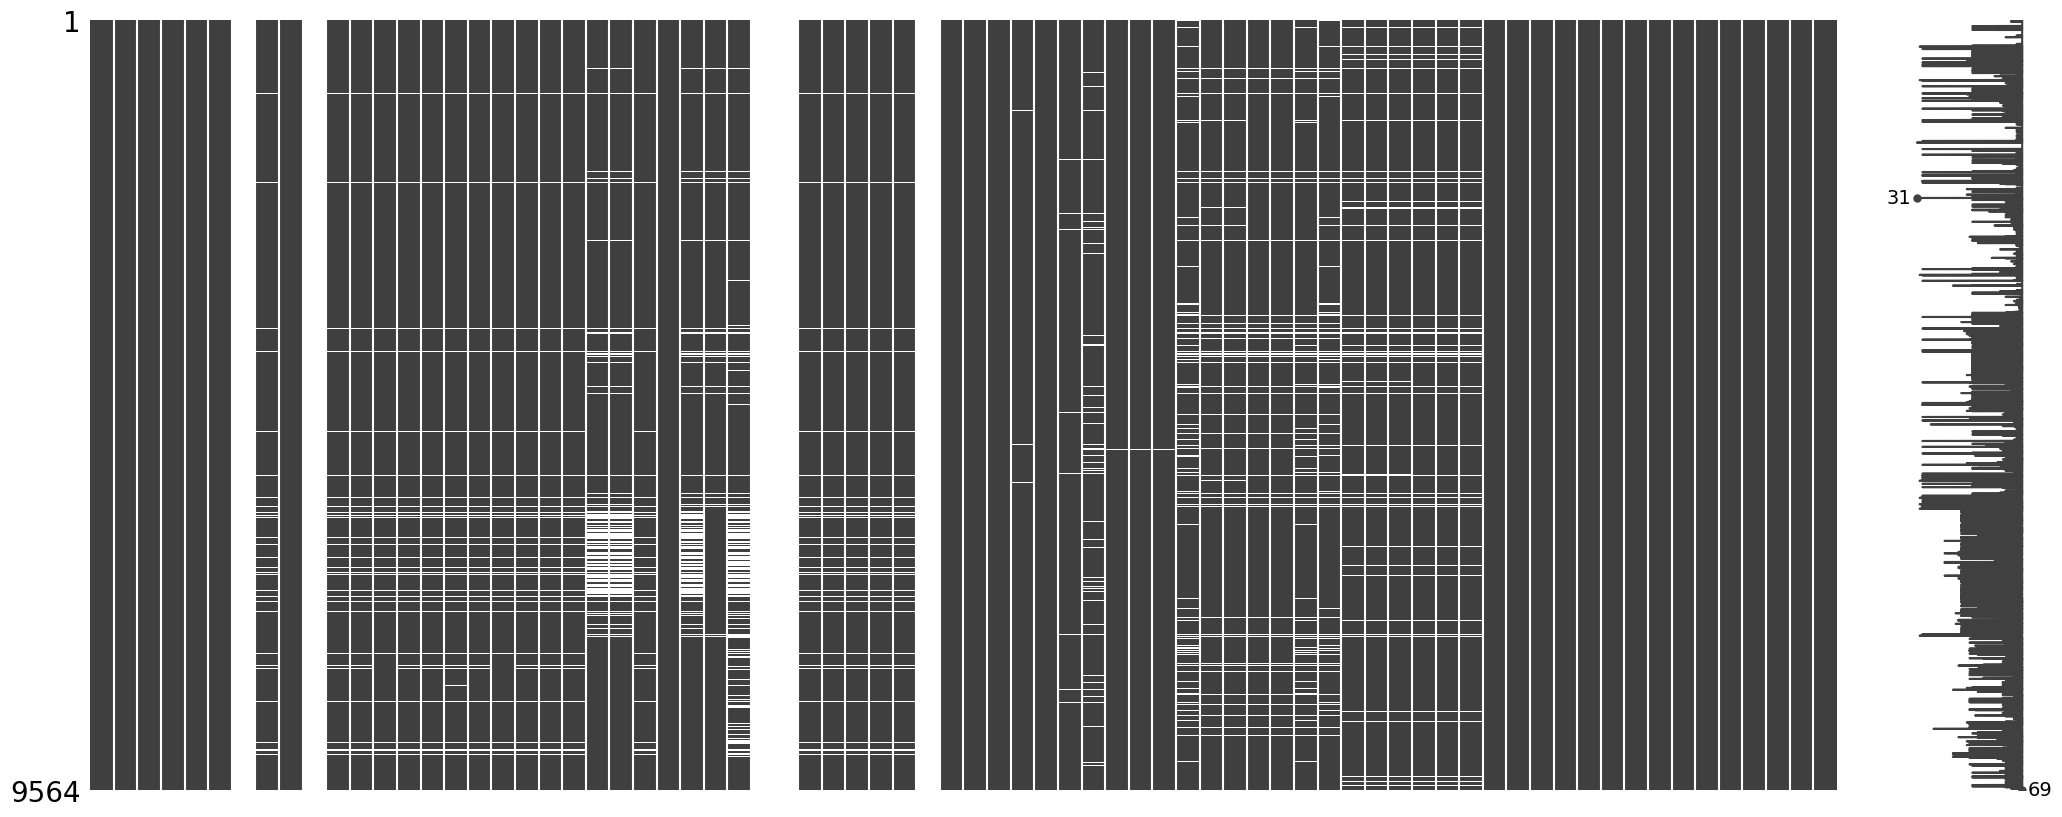

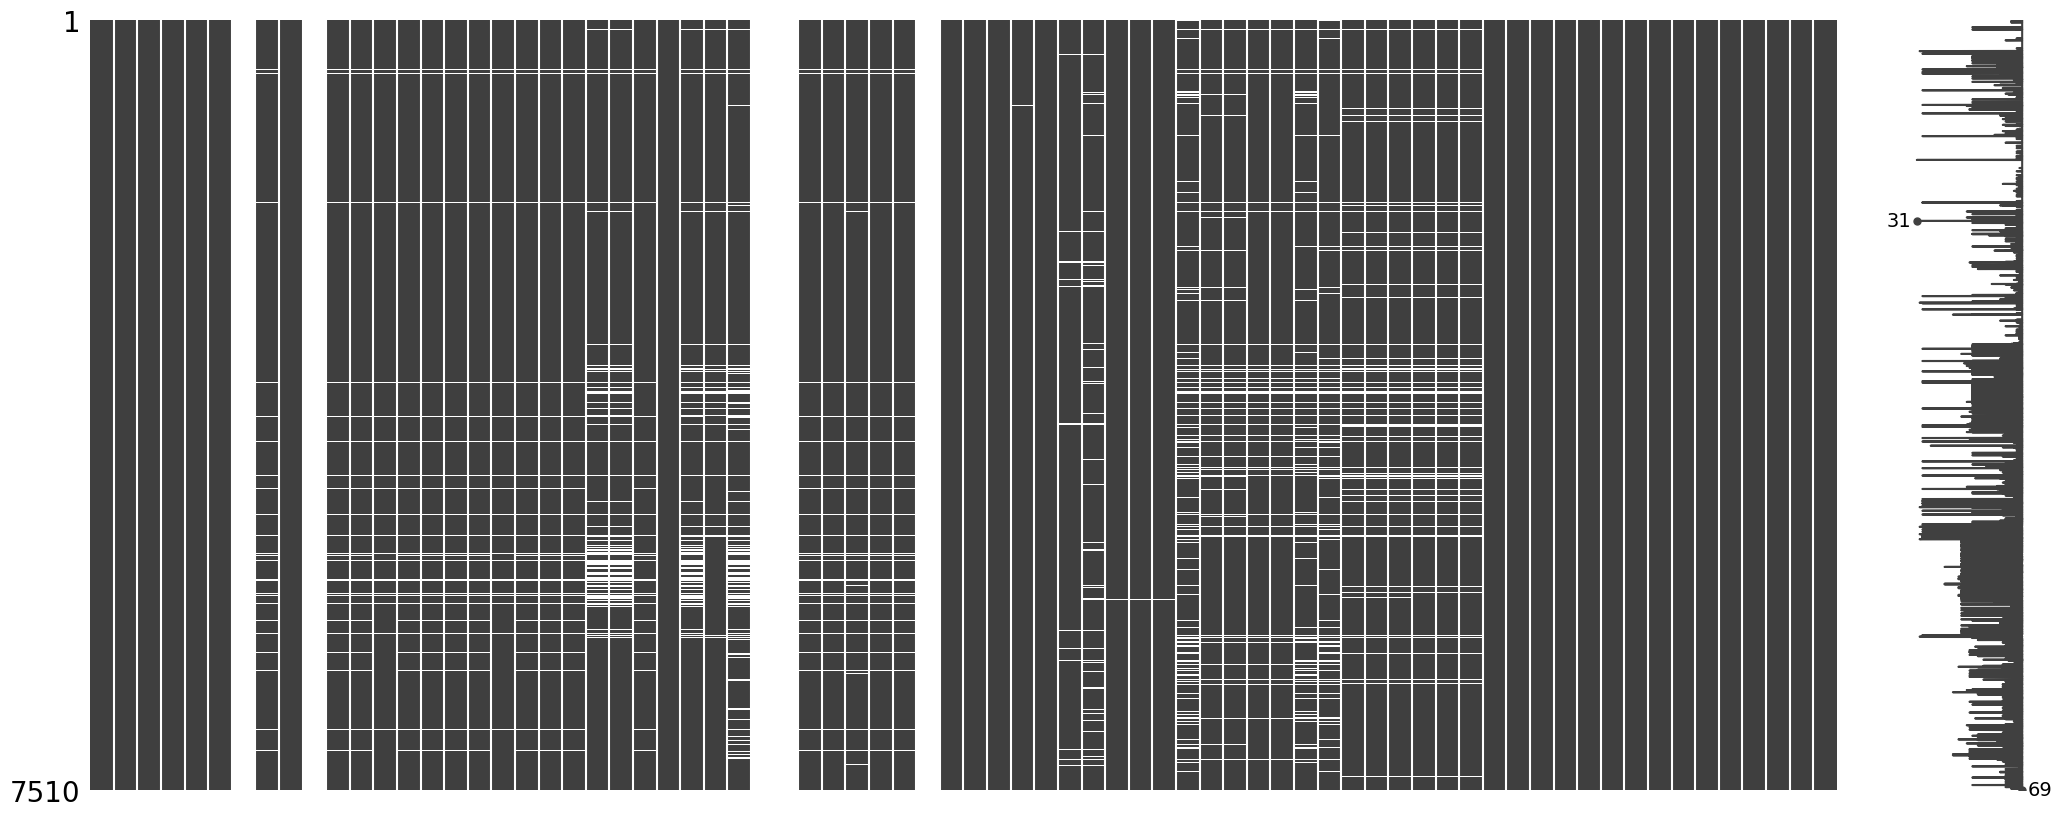

In [96]:
import missingno as msno
msno.matrix(pd.concat([data1]))
msno.matrix(pd.concat([data2]))

### 4.2.1. Drop Columns with more than 50% missing values.

Here we dropped all columns that have more than 50% of their data missing.


data shape before :  (9564, 74)
data shape after :  (9564, 69)

data shape before :  (7510, 74)
data shape after :  (7510, 69)


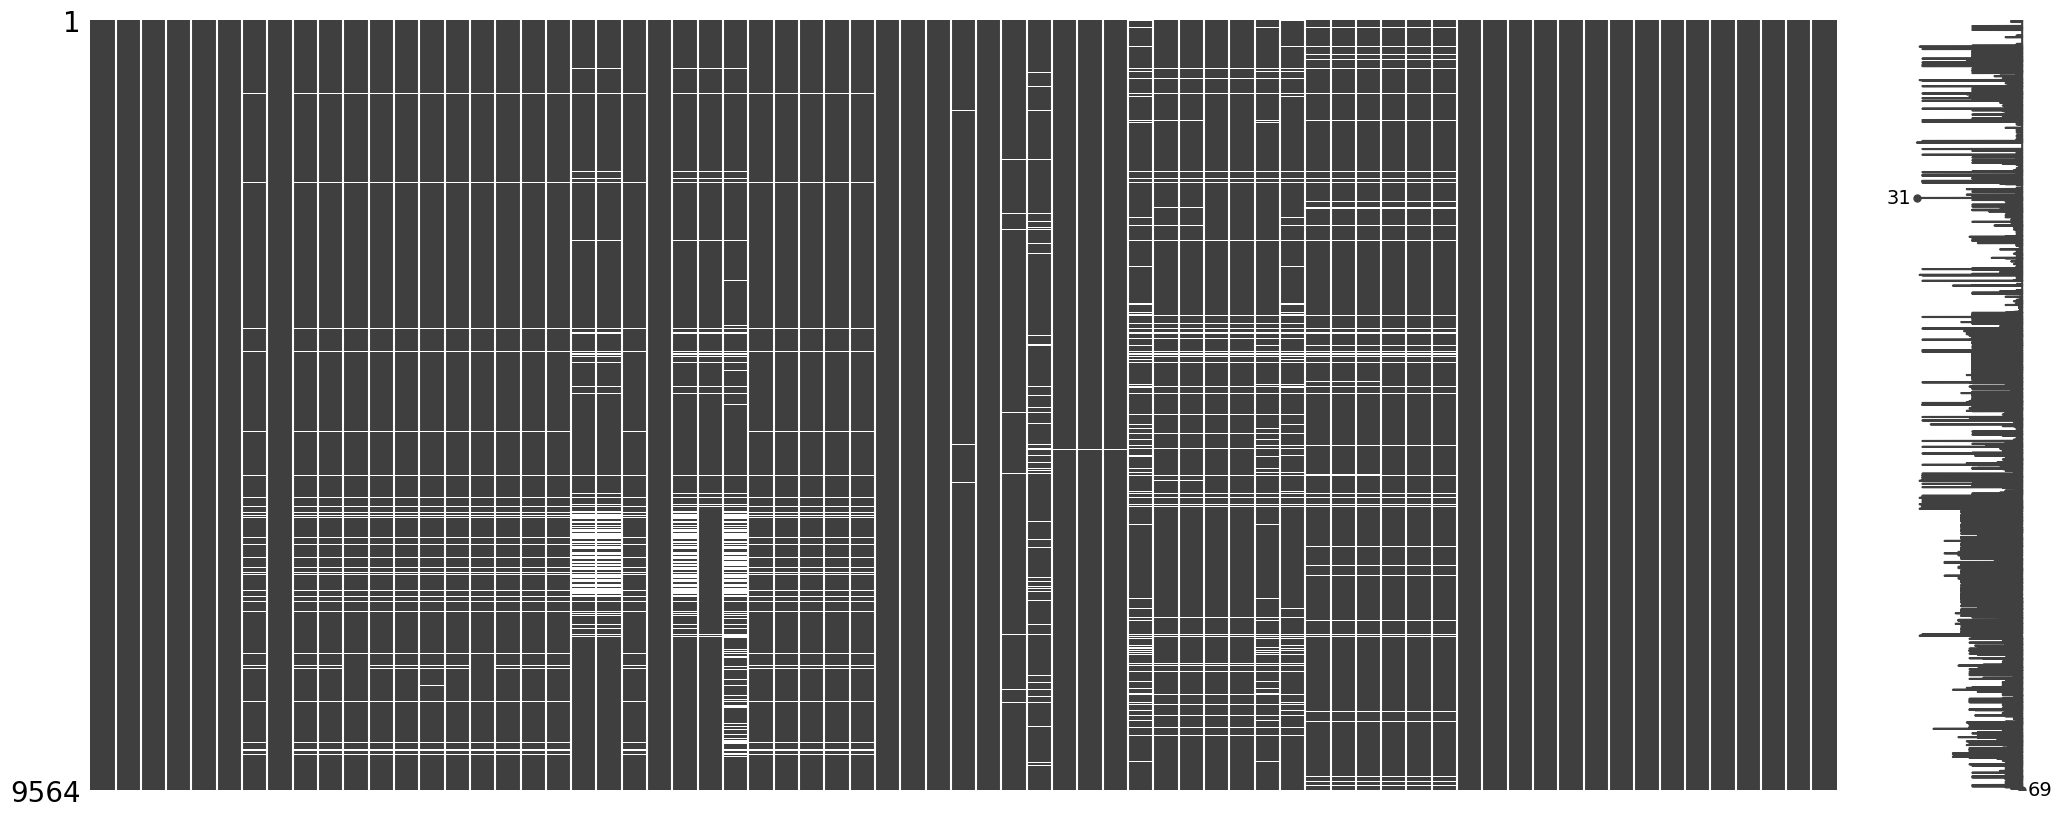

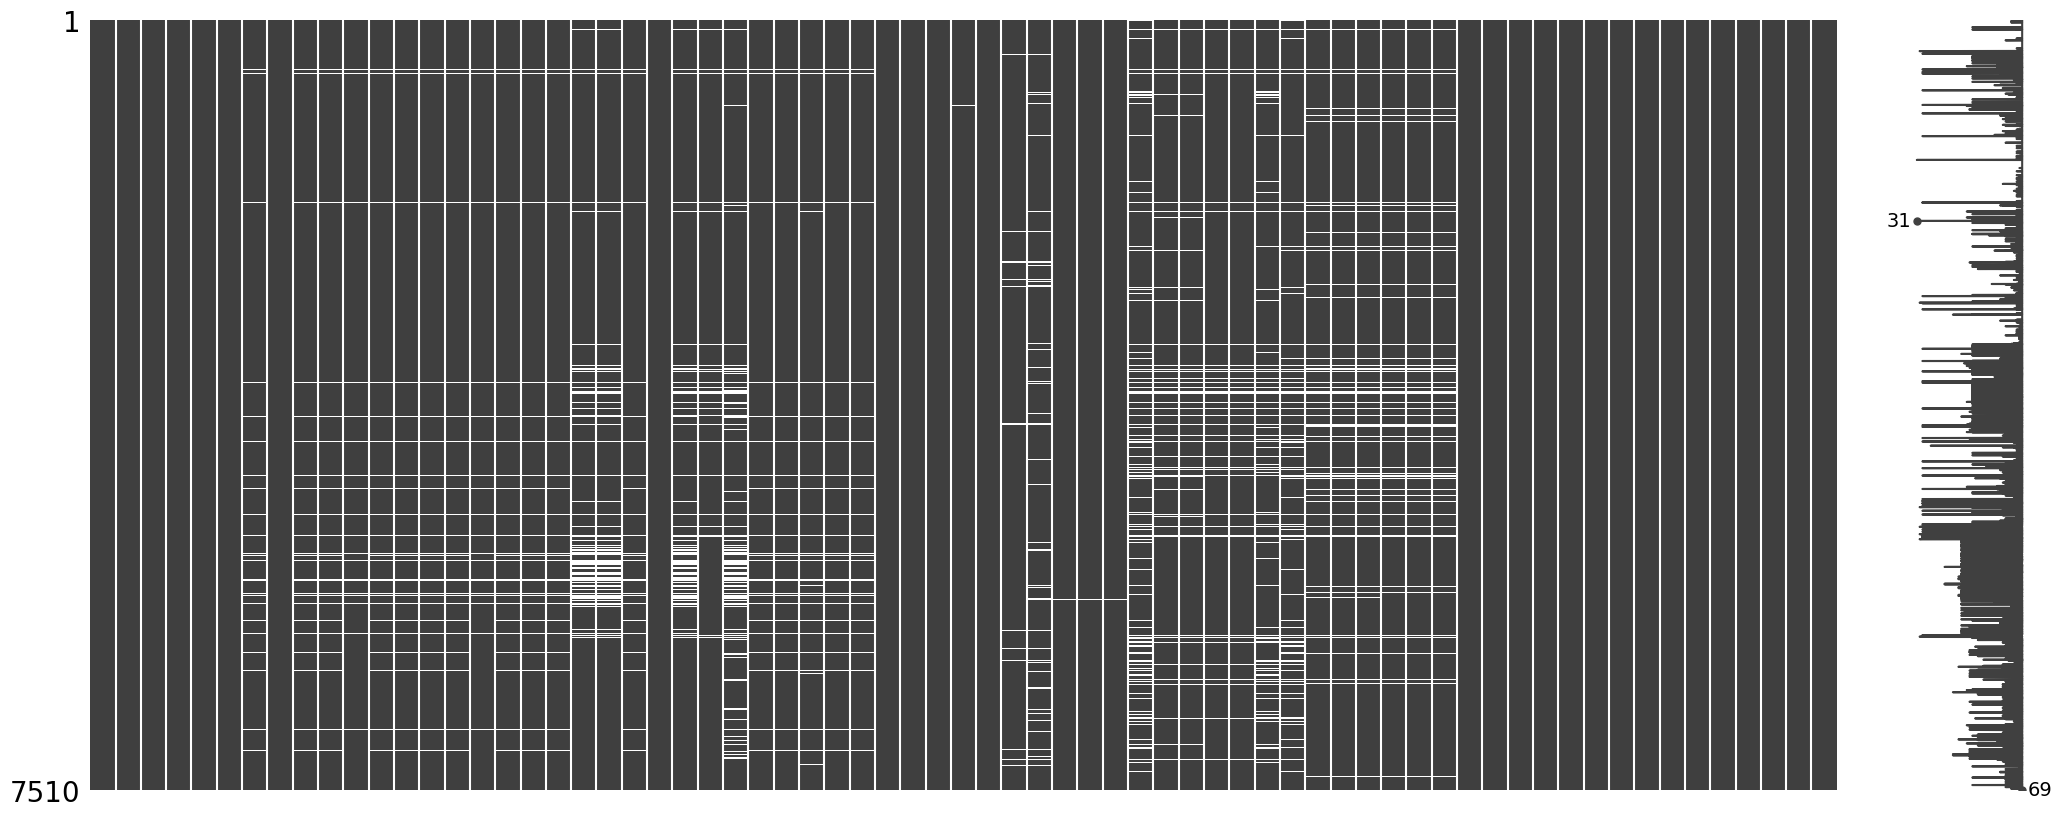

In [97]:
def drop_empty_columns(df):
    print("\ndata shape before : ", df.shape)
    df = df.loc[:, df.isnull().mean() < .5]
    msno.matrix(pd.concat([df]))
    print("data shape after : ", df.shape)
    return df

data1 = drop_empty_columns(data1)
data2 = drop_empty_columns(data2)

### 4.2.2. Drop Rows with 50%+ Missing Values


data shape before :  (9564, 69)
data shape after :  (9473, 69)

data shape before :  (7510, 69)
data shape after :  (7434, 69)


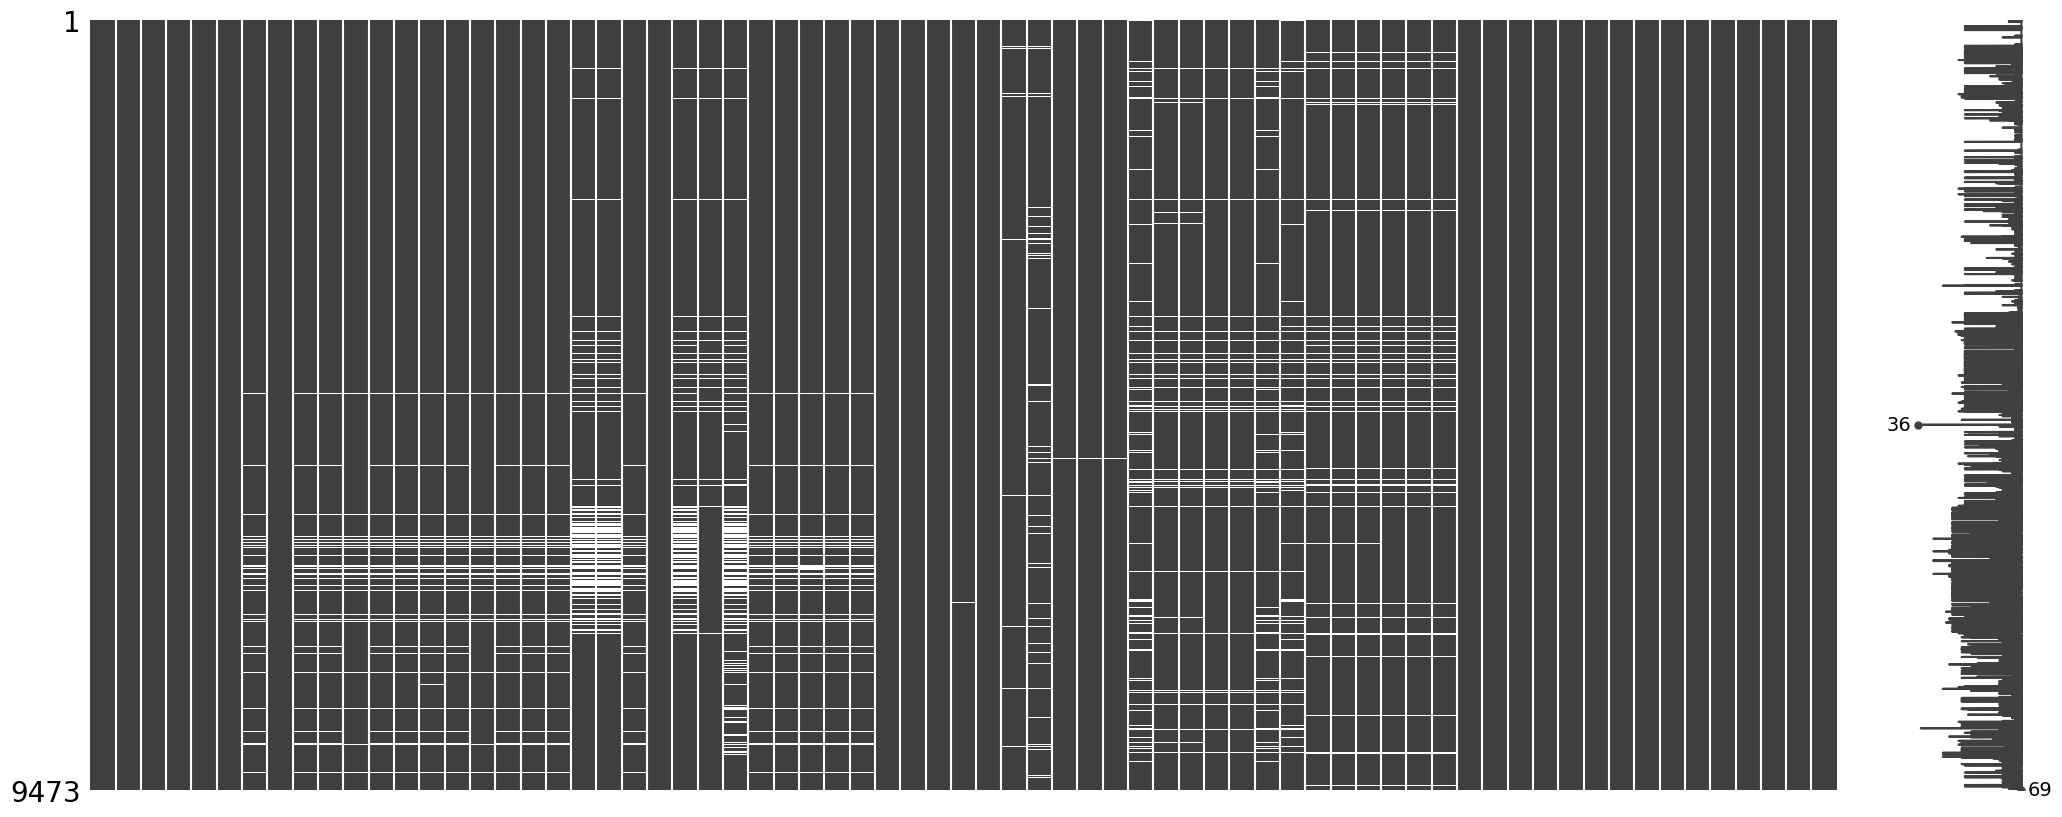

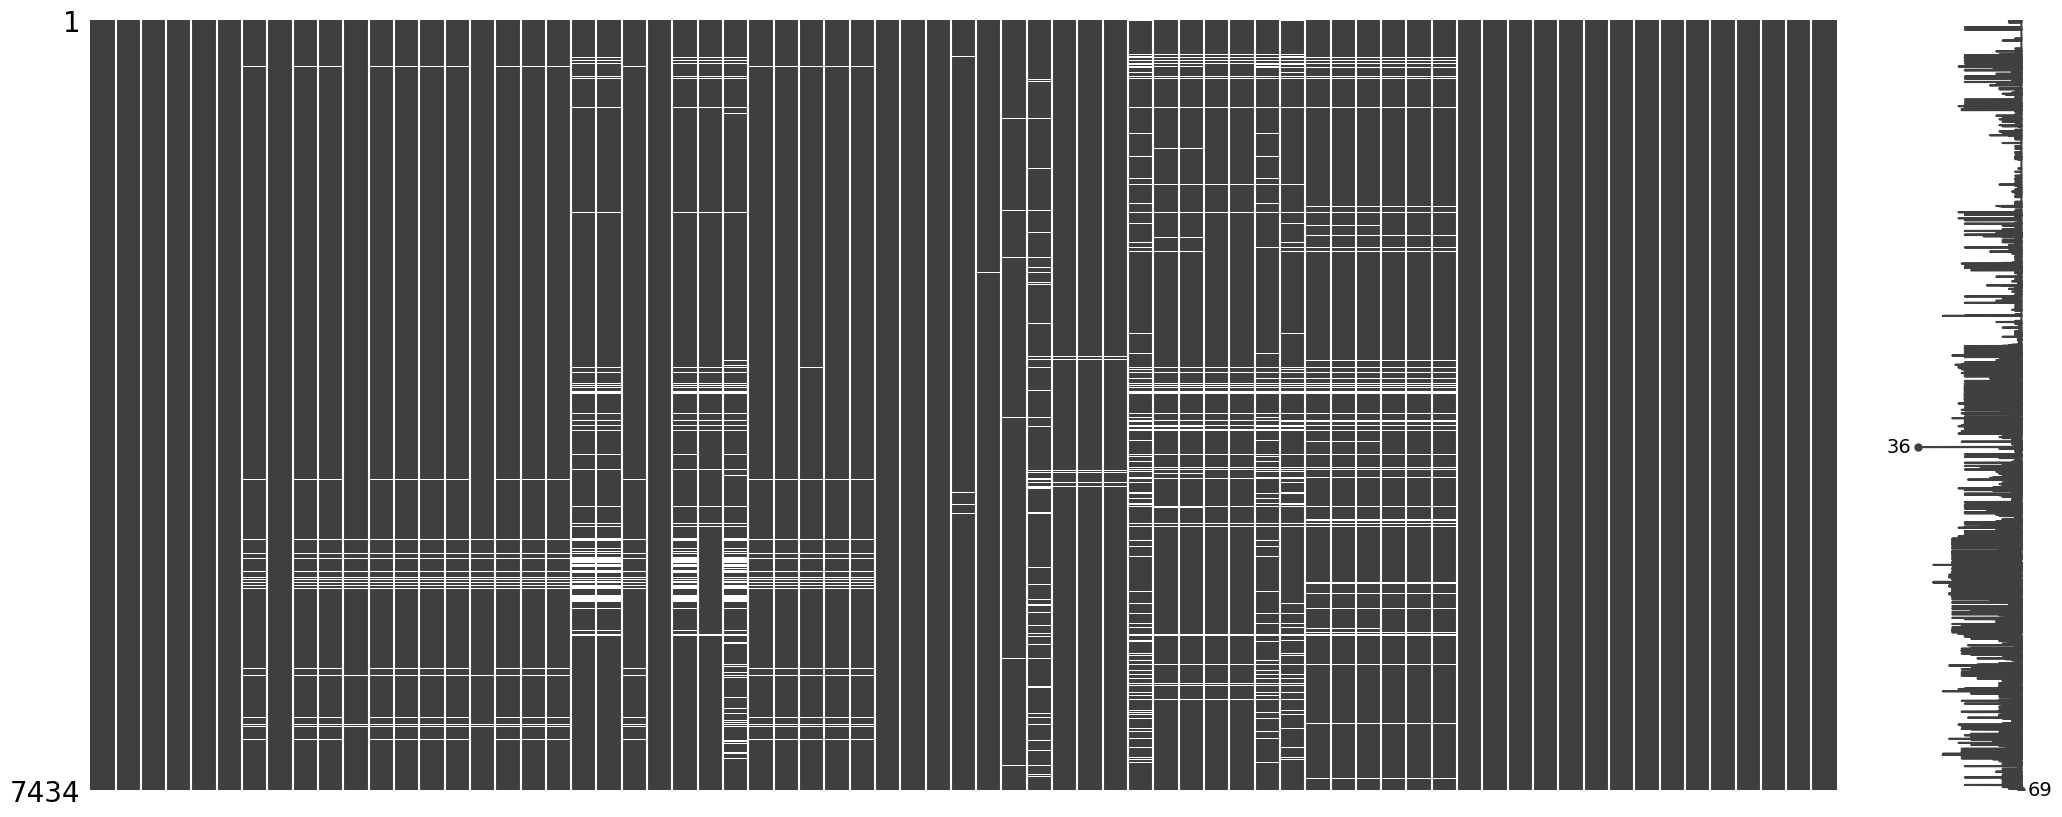

In [98]:
def drop_empty_rows(df):
    print("\ndata shape before : ", df.shape)
    per_row = []
    for index in range(len(df.index)) :
        per_row.append([index, df.iloc[index].isna().mean()])

    row_missing = pd.DataFrame(per_row, columns=['index', 'missing']).sort_values(by='missing', ascending=False)

    rows_to_delete = list(row_missing.loc[row_missing['missing'] > 0.5].index)
    df = df.drop(rows_to_delete,axis='index')

    msno.matrix(pd.concat([df]))
    print("data shape after : ", df.shape)
    return df
    
data1 = drop_empty_rows(data1)
data2 = drop_empty_rows(data2)

### 4.2.3. Impute Missing Valuews

C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\2143697503.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)
C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\2143697503.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)


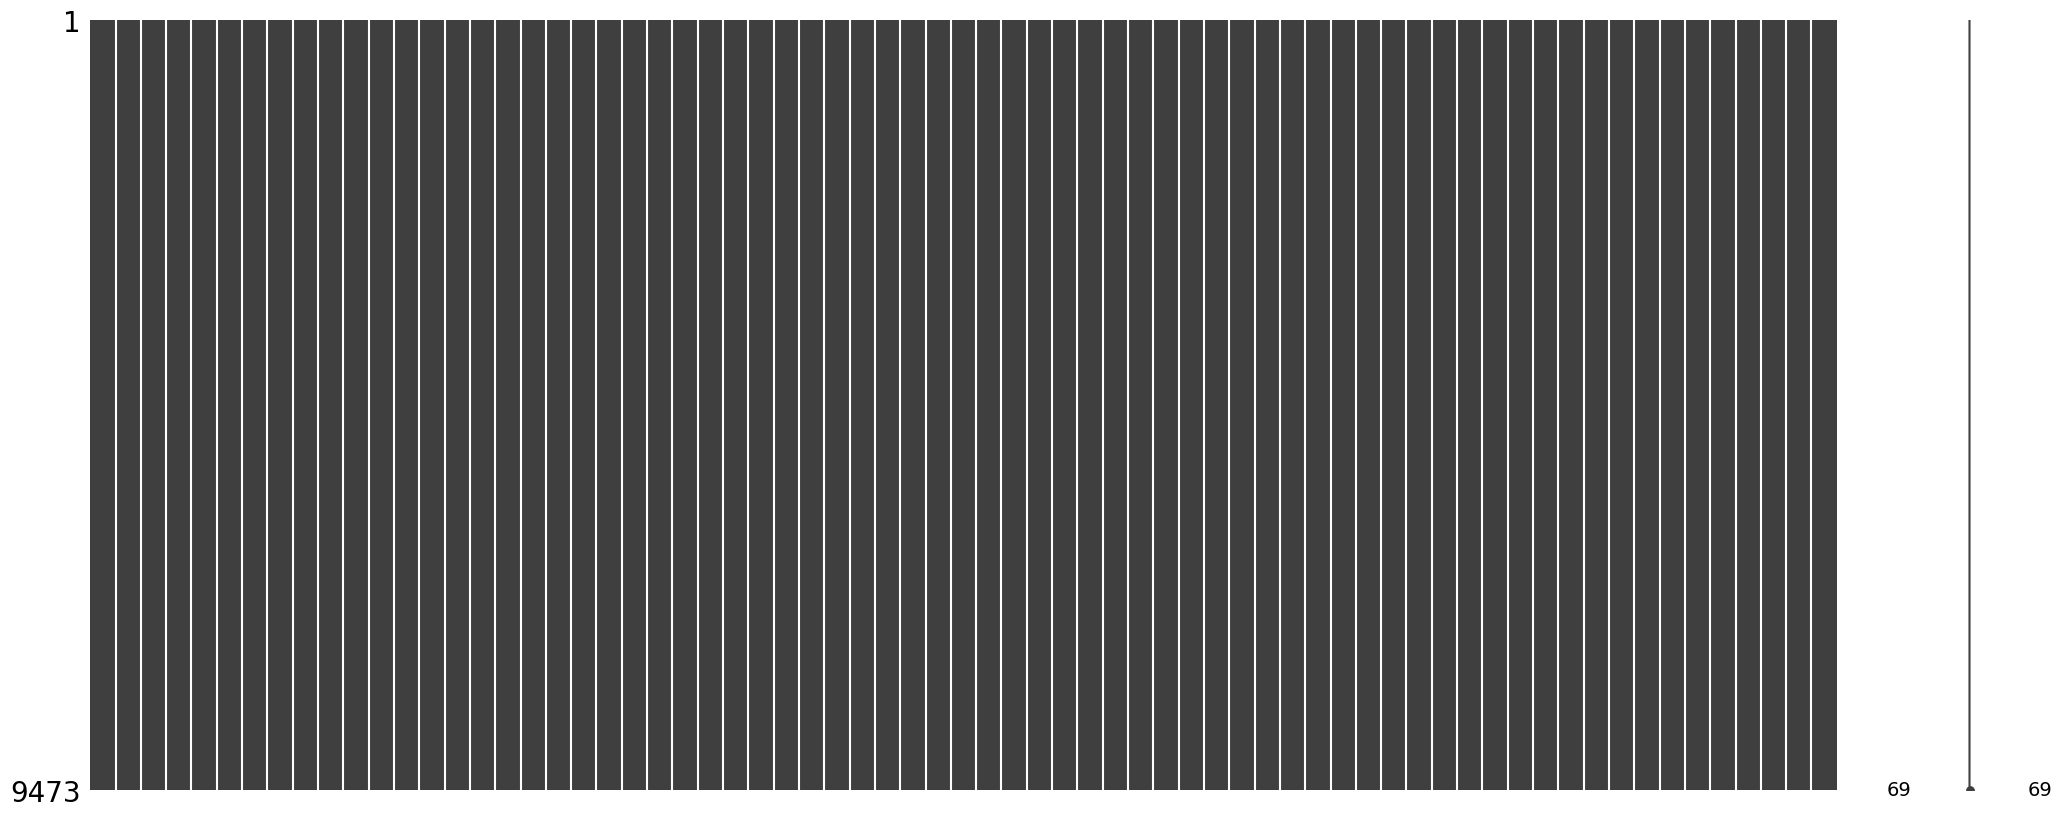

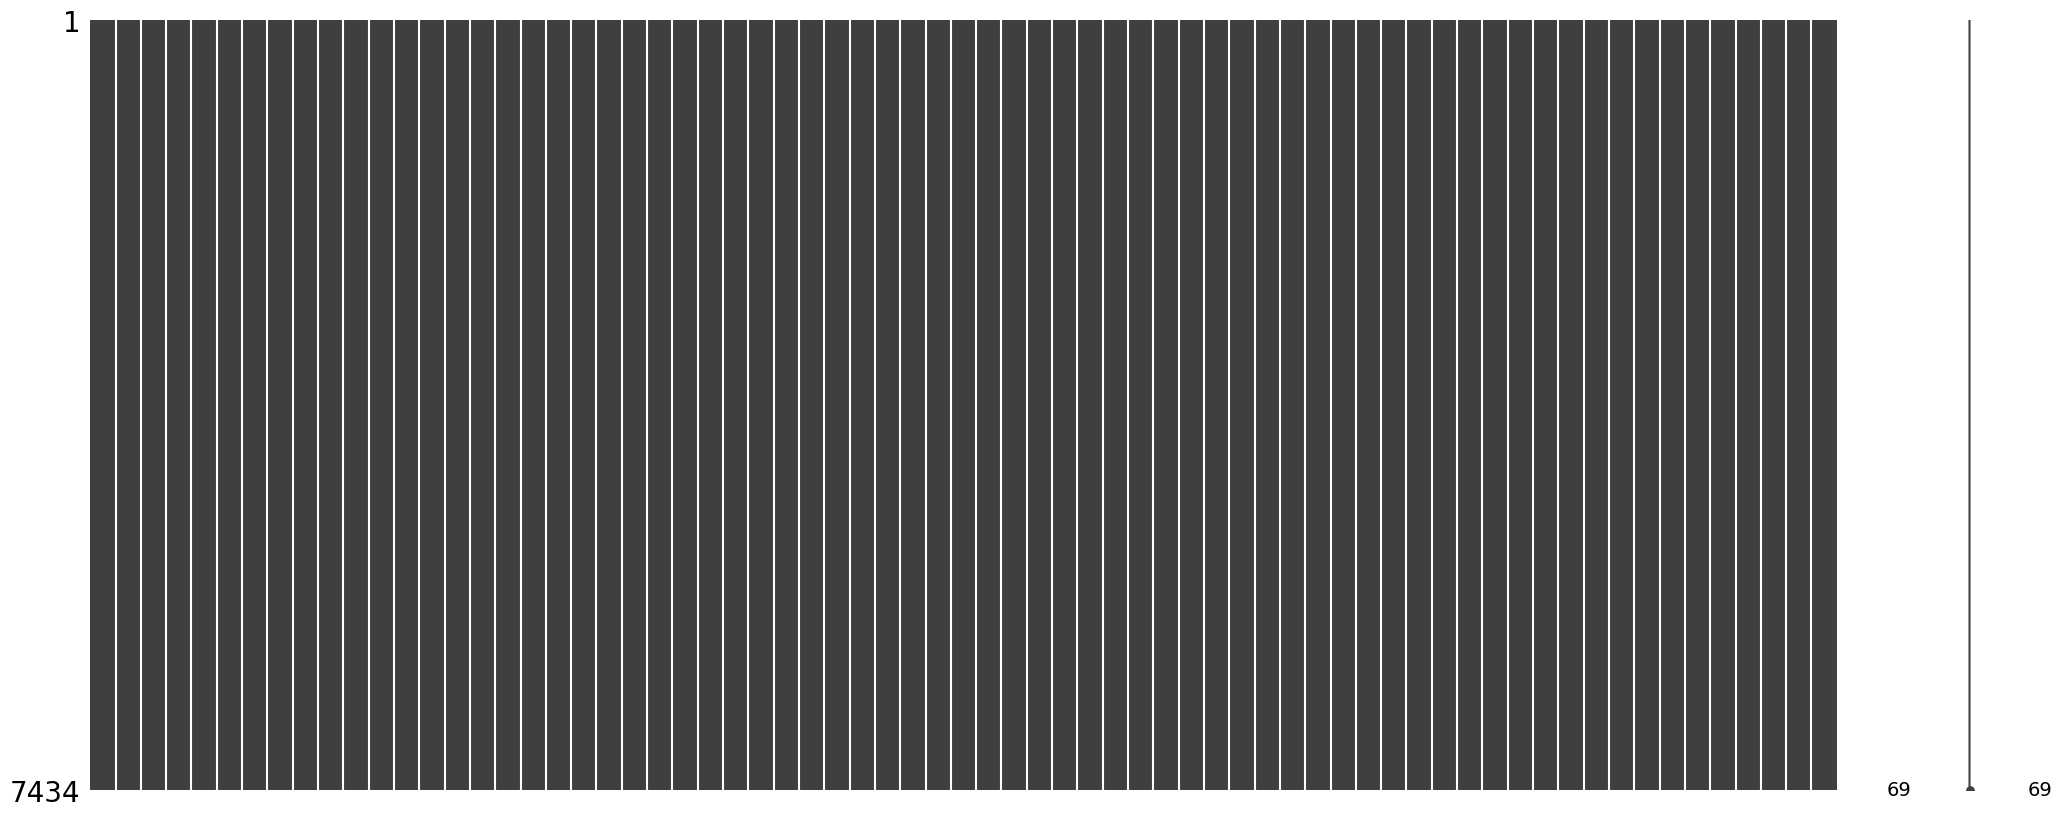

In [99]:
def impute_missing(df):
    #copy the df and remove the dispotion cat column in order to impute
    df_imputer_knn = df.copy(deep=True)

    # Impute the feature
    knnimputer = KNNImputer(n_neighbors=3)
    df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)

    msno.matrix(pd.concat([df_imputer_knn]))
    return df_imputer_knn

data1 = impute_missing(data1)
data2 = impute_missing(data2)

<a id='outliers'></a>
## 4.3. PCA Outlier Detection


In [100]:
def outlier_detection(df):
    features = df.columns[:]

    df_pca = df.loc[:, features].values
    df_pca = StandardScaler().fit_transform(df_pca)

    pca = PCA(n_components=2)  # Choose the number of principal components
    principal_components = pca.fit_transform(df_pca)
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    euclidean_distance = pd.Series(
        [sum(np.square(row)) for row in principal_components],
        name='EuclideanDistance'
    )

    df_temp_nasa = pd.concat([df, principal_df, euclidean_distance], axis=1)

    df_temp_nasa.dropna(inplace=True)
    #mark all samples with distance > 80 as outliers
    outliers = df_temp_nasa[df_temp_nasa['EuclideanDistance'] > 80]

    print("Found " + str(len(outliers)) + " outliers")
    
    # Draw the outliers
    
    # Assuming you already have the 'outliers' DataFrame
    normal_samples = df_temp_nasa.drop(outliers.index)  # Exclude outliers from normal samples

    # Plotting the normal samples
    plt.scatter(normal_samples['PC1'], normal_samples['PC2'], color='blue', label='Normal Samples', s=5)

    # Plotting the outliers
    plt.scatter(outliers['PC1'], outliers['PC2'], color='red', label='Outliers', s=5)

    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title('PCA: Outlier Detection')
    plt.legend()
    plt.show()
    
    #drop outliers and added columns 
    df_work = df_temp_nasa[df_temp_nasa['EuclideanDistance'] < 80].drop(['PC1', 'PC2', 'EuclideanDistance'], axis=1)

    return df_work

Found 182 outliers


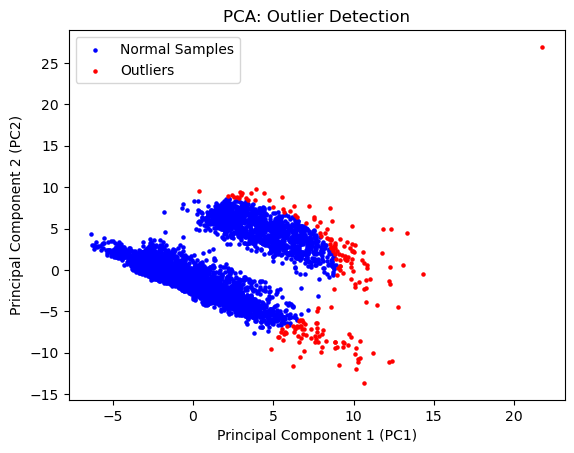

Found 376 outliers


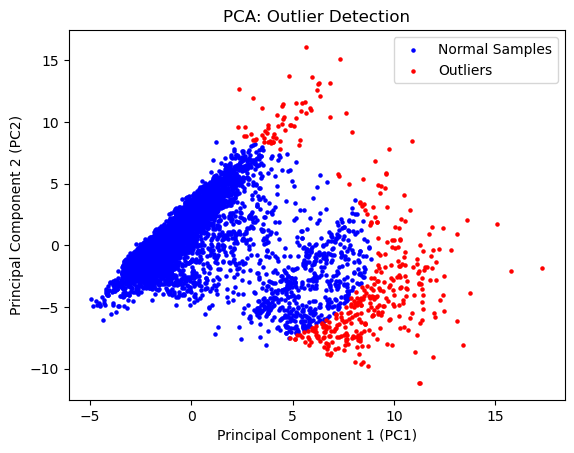

In [101]:
data1 = outlier_detection(data1)
data2 = outlier_detection(data2)

<a id='normalization'></a>
## 4.4. Normalization 

We first fit our scaler on the *train* data, and then scale our *test* data with the same scaler.

This is done to prevent data leakage in the scaling process, which may introduce bias in our models.

In [112]:
def normalization(df):
    X = df.copy().drop('ExoplanetConfirmed', axis=1)
    y = df['ExoplanetConfirmed']

    #split 75-25 train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    sc = StandardScaler()
    # Fit scaler on train data, transform it
    X_train = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    # Transform test data using same scaler
    X_test = pd.DataFrame(sc.transform (X_test), index=X_test.index, columns=X_test.columns)
    
    print("x_train shape " + str(X_train.shape) + " , x_test shape " + str(X_test.shape))
    
    return X_train, X_test, y_train, y_test

In [113]:
x1_train, x1_test, y1_train, y1_test = normalization(data1)
x2_train, x2_test, y2_train, y2_test = normalization(data2)

x_train shape (6900, 68) , x_test shape (2300, 68)
x_train shape (5236, 68) , x_test shape (1746, 68)


<a id='corr'></a>
## 4.5. Check for Correlated Features


In [117]:
def correlated_features(df):
    corr_matrix = df.corr(method="pearson")
    
    # select upper traingle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    #select columns with coefficient of 0.95+ or -0.95- aka high negative/positive linear correlation
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.95) or any(upper[column] <= -0.95)]
    
    print("Found " + str(len(to_drop)) + "  features with pearson correlation of +-0.95 or more")
    
    sns.set(font_scale=0.8)

    # Create labels for the correlation matrix
    labels = np.where(np.abs(corr_matrix)>0.95, "S",
                      np.where(np.abs(corr_matrix)>0.5, "M",
                               np.where(np.abs(corr_matrix)>0.15, "W", "")))

    # Plot correlation matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix)), square=True,
                center=0, annot=labels, fmt='', linewidths=.5,
                cmap="vlag", cbar_kws={"shrink": 0.8})
    
    return to_drop


def drop_correlated_features(x_train, x_test):
    print("BEFORE: x_train shape " + str(x_train.shape) + " , x_test shape " + str(x_test.shape))
    #get the correalted features
    to_drop = correlated_features(pd.concat([x_train, x_test], axis=0))

    # drop the correlated features for both train and test data
    x_train = x_train.drop(to_drop, axis=1)
    x_test = x_test.drop(to_drop, axis=1)
    print("AFTER: x_train shape " + str(x_train.shape) + " , x_test shape " + str(x_test.shape))
    return x_train, x_test

BEFORE: x_train shape (6900, 68) , x_test shape (2300, 68)
Found 13  features with pearson correlation of +-0.95 or more


C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\887969905.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


AFTER: x_train shape (6900, 55) , x_test shape (2300, 55)


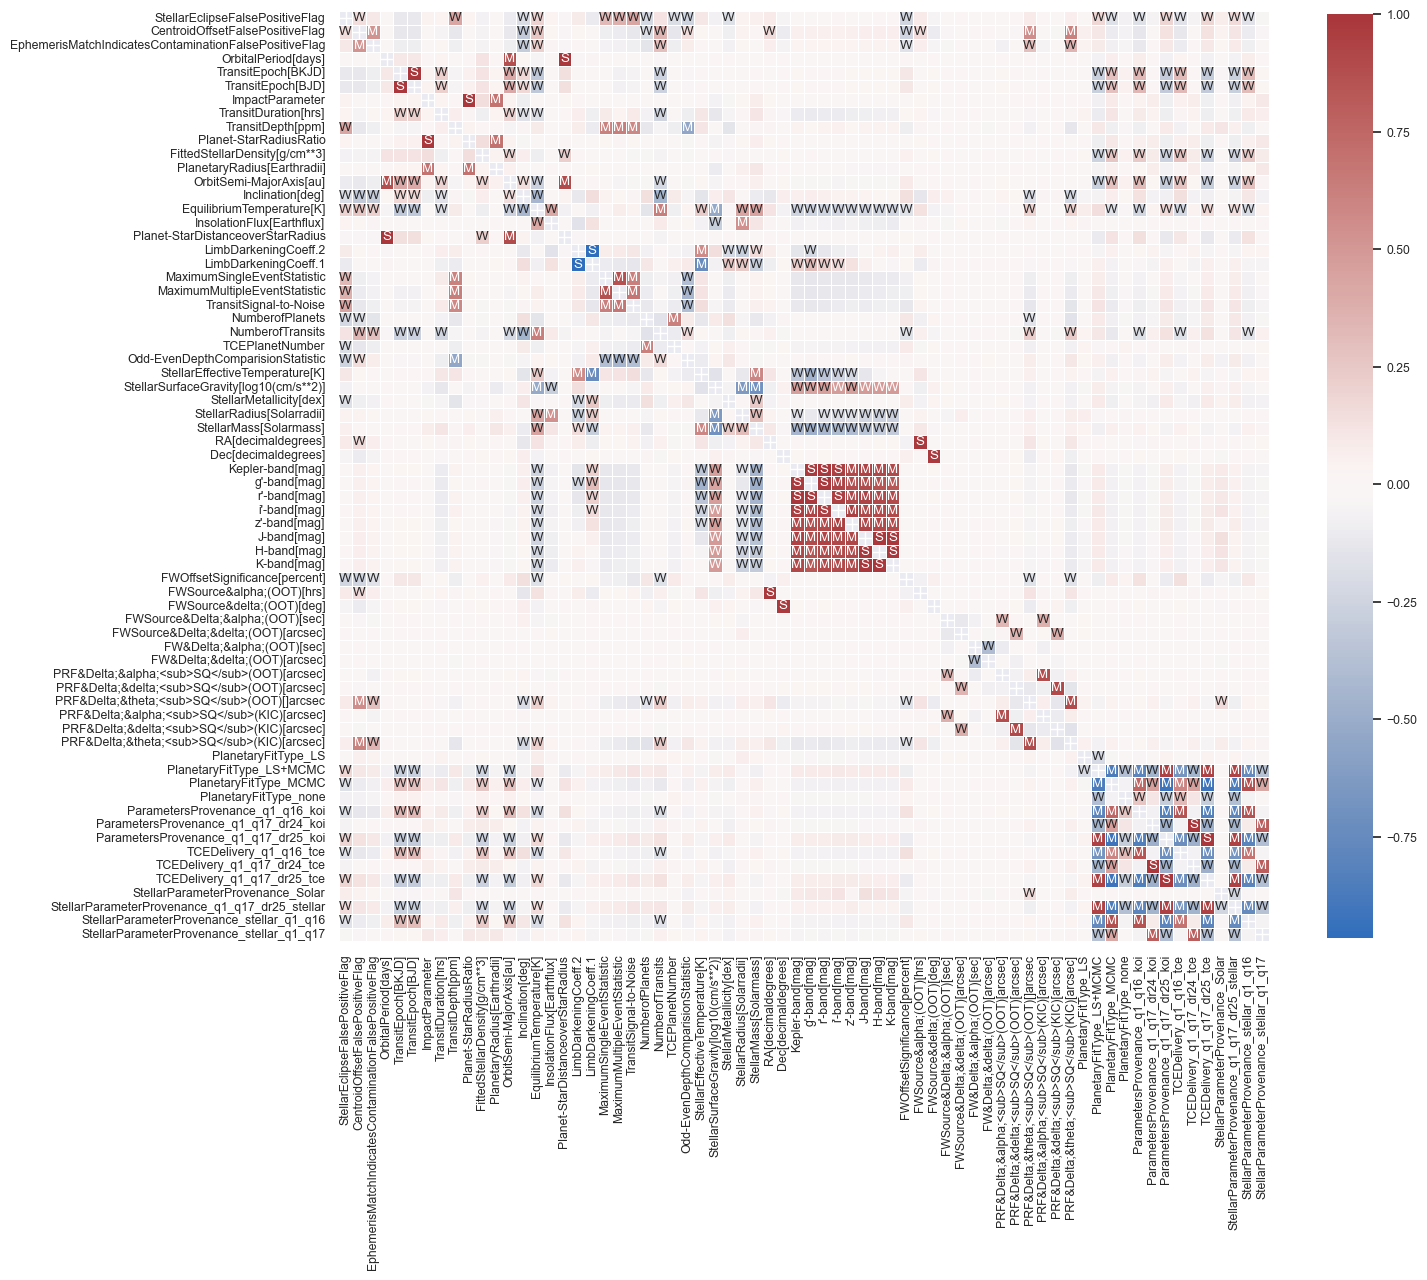

In [118]:
x1_train, x1_test = drop_correlated_features(x1_train, x1_test)

BEFORE: x_train shape (5236, 68) , x_test shape (1746, 68)
Found 12  features with pearson correlation of +-0.95 or more


C:\Users\Nareed\AppData\Local\Temp\ipykernel_10448\887969905.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


AFTER: x_train shape (5236, 56) , x_test shape (1746, 56)


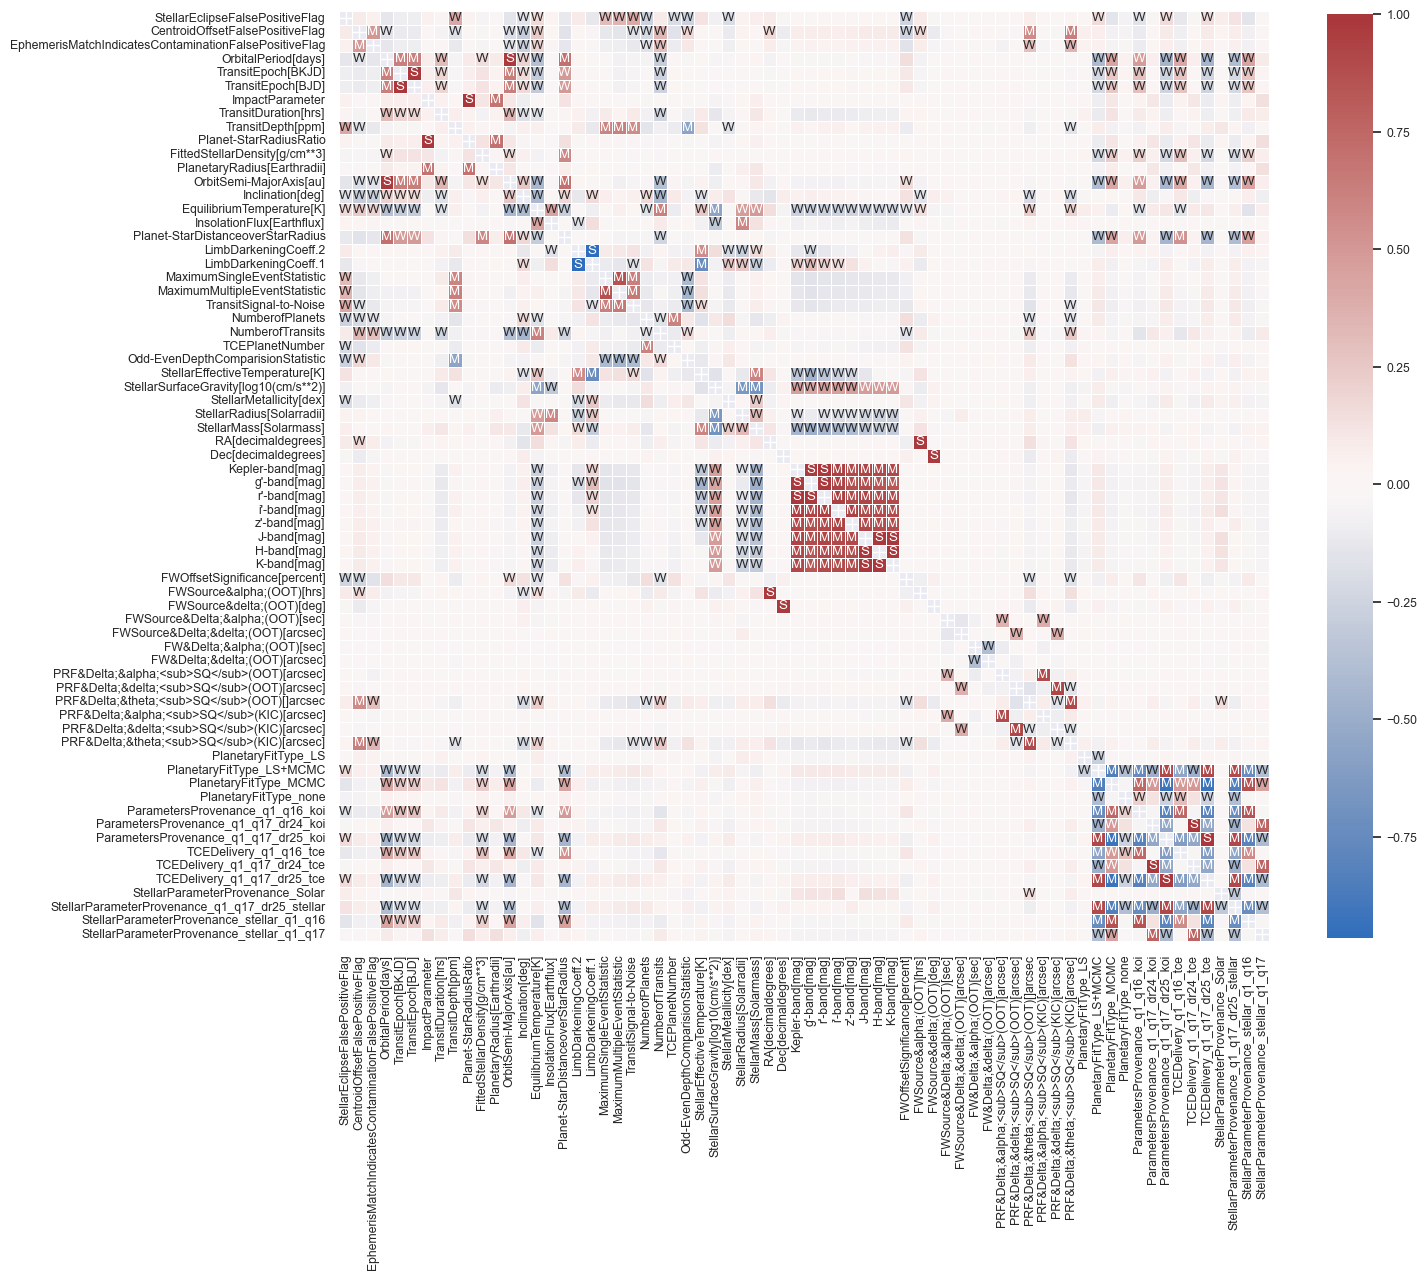

In [119]:
x2_train, x2_test = drop_correlated_features(x2_train, x2_test)

<a id='balance'></a>
## 4.6. Class Balancing


##### Before we start class balancing the training data, we need to insure that it has a similar class balance to the original dataset.

In [121]:
#for the full dataset

data_balance = data1['ExoplanetConfirmed'].value_counts()
train_balance = y1_train.value_counts()

print(data_balance[1] / data_balance[0])
print(train_balance[1] / train_balance[0])

0.4060828366192878
0.4061544732015488


In [122]:
#for the confirmed/false-positive datasest

data_balance = data2['ExoplanetConfirmed'].value_counts()
train_balance = y2_train.value_counts()

print(data_balance[1] / data_balance[0])
print(train_balance[1] / train_balance[0])

0.6054265348355944
0.6056424409690279


The class balance is similar in both the train and orignal datasets, we can continue.

#### We will try both oversampling (SMOTE+TOMEK) and undersampling (CNN+TOMEK) strategies to see which one yields better results.

In [125]:
def class_balancing(x_train, y_train):
    print('\nOriginal dataset shape %s' % Counter(y_train))
    
    print("\nGenerate synthetic data using SMOTE")
    # Generate synthetic data using SMOTE
    # Remove noisy data using TOMEK Links undersampling
    smt = SMOTETomek(random_state=42)
    X_res_SMOTE, y_res_SMOTE = smt.fit_resample(x_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_res_SMOTE))

    print("- " * 5)
    
    print("\nCNN undersampling")

    # Perform CNN undersampling
    cnn = CondensedNearestNeighbour(random_state=42)  
    X_res_cnn, y_res_cnn = cnn.fit_resample(x_train, y_train)  

    # Remove noisy data with TOMEK Links undersampling
    tl = TomekLinks()
    X_res_cnn, y_res_cnn = tl.fit_resample(X_res_cnn, y_res_cnn)

    print('Resampled dataset shape %s' % Counter(y_res_cnn))

    return X_res_SMOTE, y_res_SMOTE, X_res_cnn, y_res_cnn


##### data1 - all samples

In [126]:
x1_res_SMOTE, y1_res_SMOTE, x1_res_cnn, y1_res_cnn = class_balancing(x1_train, y1_train)


Original dataset shape Counter({0.0: 4907, 1.0: 1993})

Generate synthetic data using SMOTE
Resampled dataset shape Counter({0.0: 4877, 1.0: 4877})
- - - - - 

CNN undersampling
Resampled dataset shape Counter({1.0: 1790, 0.0: 1049})


##### data2 - confirmed and fp only 

In [127]:
x2_res_SMOTE, y2_res_SMOTE, x2_res_cnn, y2_res_cnn = class_balancing(x2_train, y2_train)


Original dataset shape Counter({0.0: 3261, 1.0: 1975})

Generate synthetic data using SMOTE
Resampled dataset shape Counter({1.0: 3254, 0.0: 3254})
- - - - - 

CNN undersampling
Resampled dataset shape Counter({1.0: 1948, 0.0: 441})


***

<a id='feature-selection'></a>
## 4.7. Feature Selection

### We will preform feature selection for the different results the class balancing stategies yeilds.

Feature selection will be calculated for 4 different sets
1. All data samples (data1) after being balanced using oversampling (SMOTE and TOMEK).
2. All data samples (data1) after being balanced using undersampling (CNN and TOMEK).
3. Confirmed and false-positive samples (data2) after being balanced using oversampling (SMOTE and TOMEK).
4. Confirmed and false-positive samples (data2) after being balanced using undersampling (CNN and TOMEK).

In all the threshold regarding which feaures are important and which are done is taken at 0.001

In [169]:
# set threshold

THRESH = 0.001

In [170]:
def feature_selection(dataset, balancing_tec, X, y, X_test, importance_threshold):
    print()
    print("** " * 20)
    print("Handling " + dataset + " " + balancing_tec)
    
    # create and fit a random forest classifier
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)
    
    result = permutation_importance(
    forest, X, y, n_repeats=10, random_state=42, n_jobs=2)
    
    feature_names = [f"feature {i}" for i in range(X.shape[1])]

    forest_importances = pd.Series(result.importances_mean, index=X.columns)
    
    d = forest_importances.sort_values(ascending=False).values
    l = forest_importances.sort_values(ascending=False).index
    
    #plot the features
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.bar(l1, d1, color='b')
    plt.title("Feature importances - " + dataset + " - " + balancing_tec, fontsize=14, fontweight='bold')
    plt.ylabel("Mean accuracy decrease")
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create a filtered datasets with only the most important features.
    # Oversampled importances
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': forest_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    print("The selected features and their importance:")
    print(importance_df.loc[importance_df['Importance'] >= importance_threshold].drop(columns='Feature'))

    important_features = importance_df[importance_df['Importance'] >= importance_threshold]['Feature']
    X = X[important_features]
    X_test = X_test[important_features]

    return X, X_test

** ** ** ** ** ** ** ** ** ** 
Handling data1 (all) oversampling (SMOTE+TOMEK)


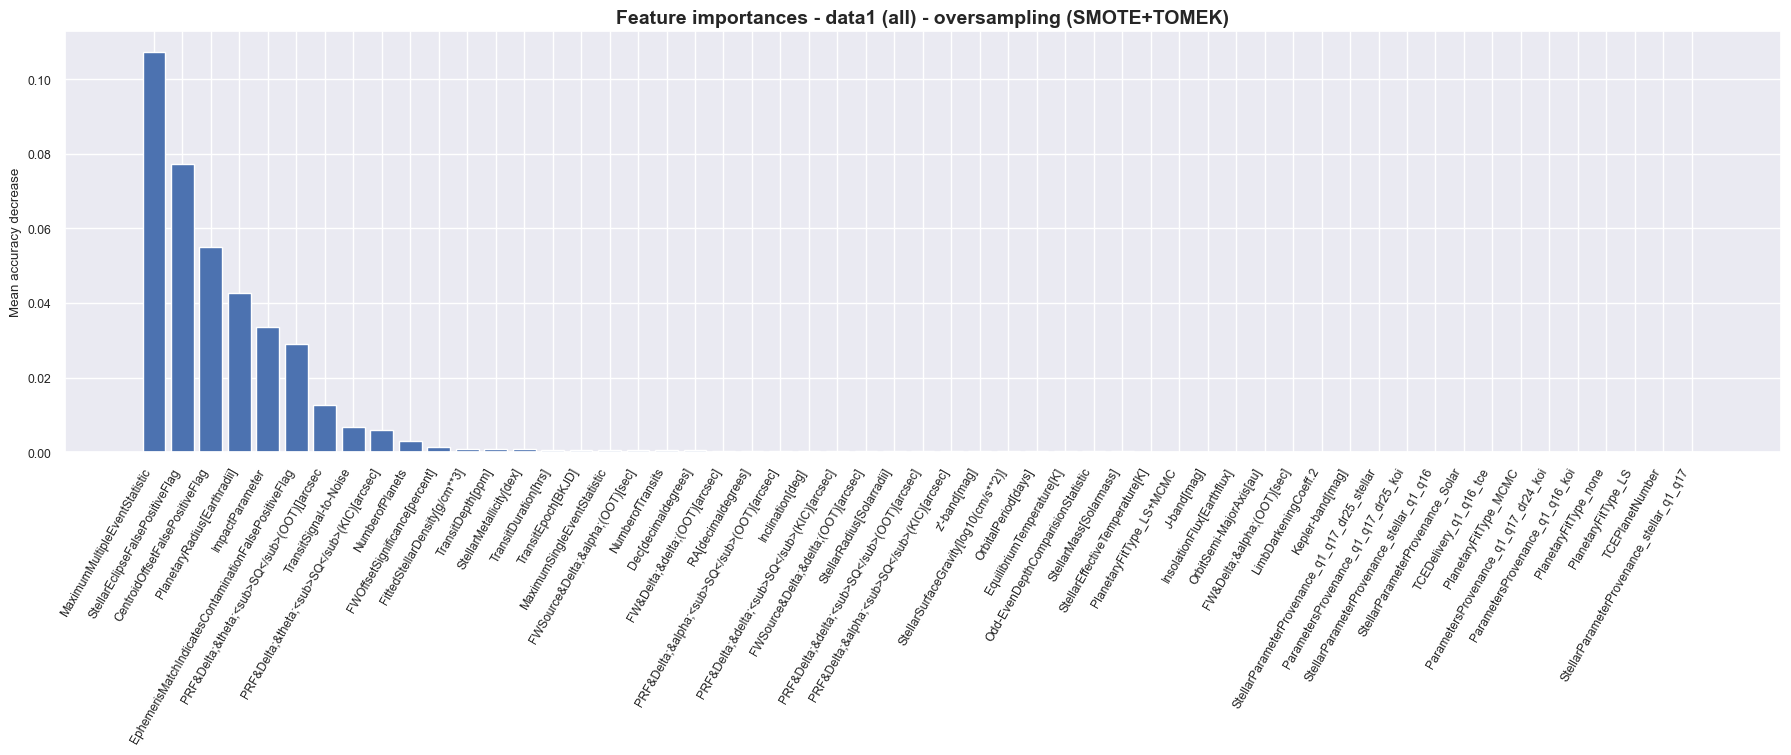

The selected features and their importance:
                                                    Importance
MaximumMultipleEventStatistic                         0.107412
StellarEclipseFalsePositiveFlag                       0.077271
CentroidOffsetFalsePositiveFlag                       0.054911
PlanetaryRadius[Earthradii]                           0.042793
ImpactParameter                                       0.033504
EphemerisMatchIndicatesContaminationFalsePositi...    0.028921
PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec           0.012754
TransitSignal-to-Noise                                0.006828
PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec]           0.005987
NumberofPlanets                                       0.003055
FWOffsetSignificance[percent]                         0.001446
** ** ** ** ** ** ** ** ** ** 
Handling data1 (all) undersampling (CNN+TOMEK)


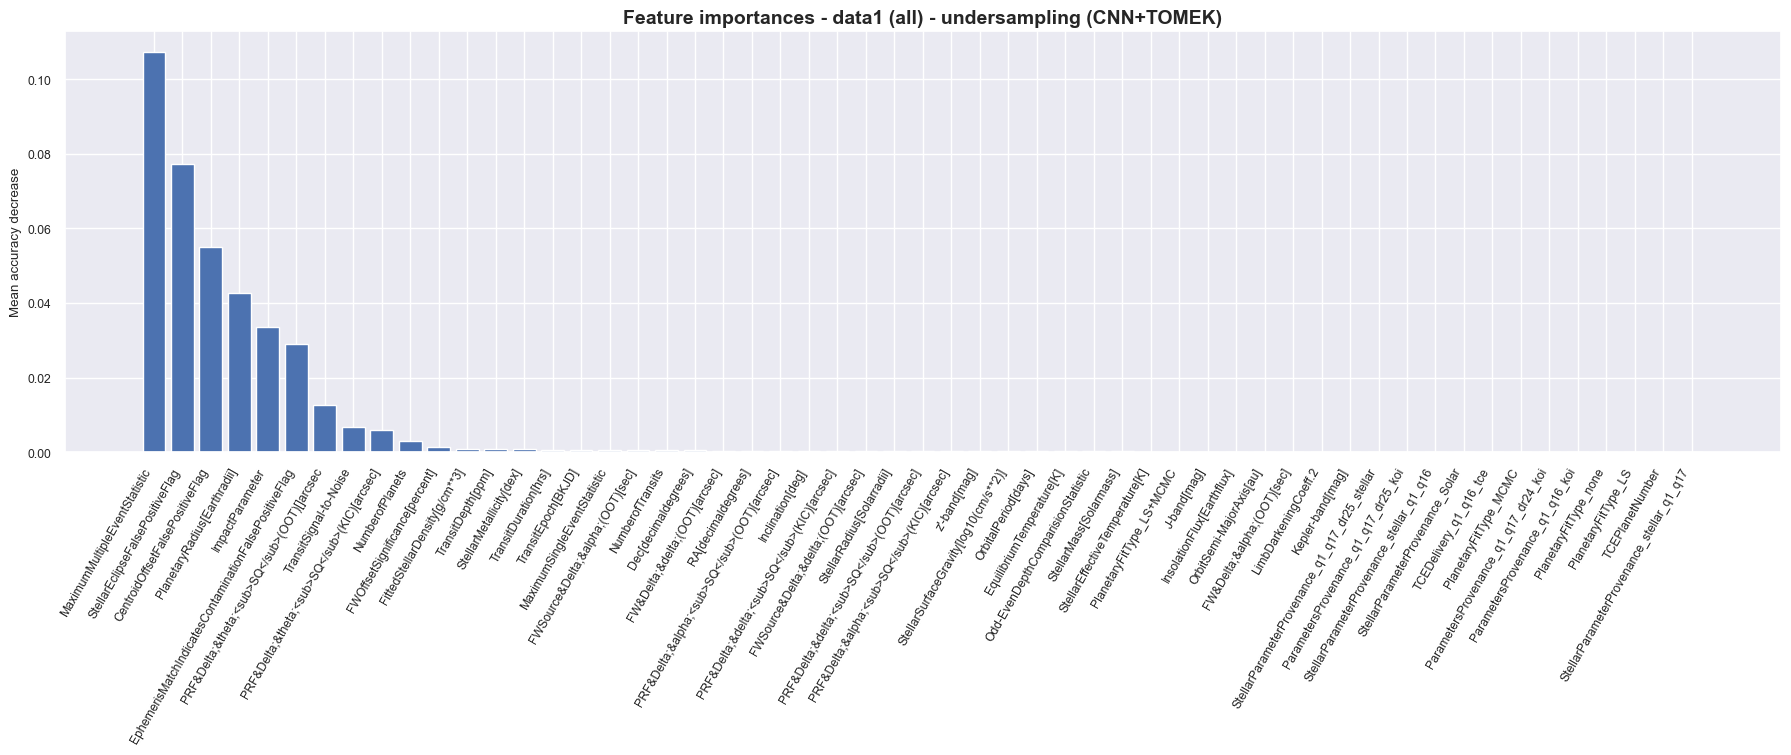

The selected features and their importance:
                                             Importance
MaximumMultipleEventStatistic                  0.135858
PlanetaryRadius[Earthradii]                    0.034061
StellarEclipseFalsePositiveFlag                0.028320
ImpactParameter                                0.016520
PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec    0.014195
TransitSignal-to-Noise                         0.010673
NumberofPlanets                                0.006235
PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec]    0.003205
MaximumSingleEventStatistic                    0.002677
FittedStellarDensity[g/cm**3]                  0.002360
StellarMetallicity[dex]                        0.001973
PRF&Delta;&alpha;<sub>SQ</sub>(OOT)[arcsec]    0.001691
FW&Delta;&delta;(OOT)[arcsec]                  0.001198
TransitEpoch[BKJD]                             0.001057


In [166]:
# run feature selection for data1 (all samples) for both version of oversampled and undersampled

x1_train_os, x1_test_os = feature_selection('data1 (all)', 'oversampling (SMOTE+TOMEK)', 
                                            x1_res_SMOTE, y1_res_SMOTE, x1_test, THRESH)

x1_train_us, x1_test_us = feature_selection('data1 (all)', 'undersampling (CNN+TOMEK)', 
                                            x1_res_cnn, y1_res_cnn, x1_test, THRESH)


** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** 
Handling data2 (confirmed&fp) oversampling (SMOTE+TOMEK)


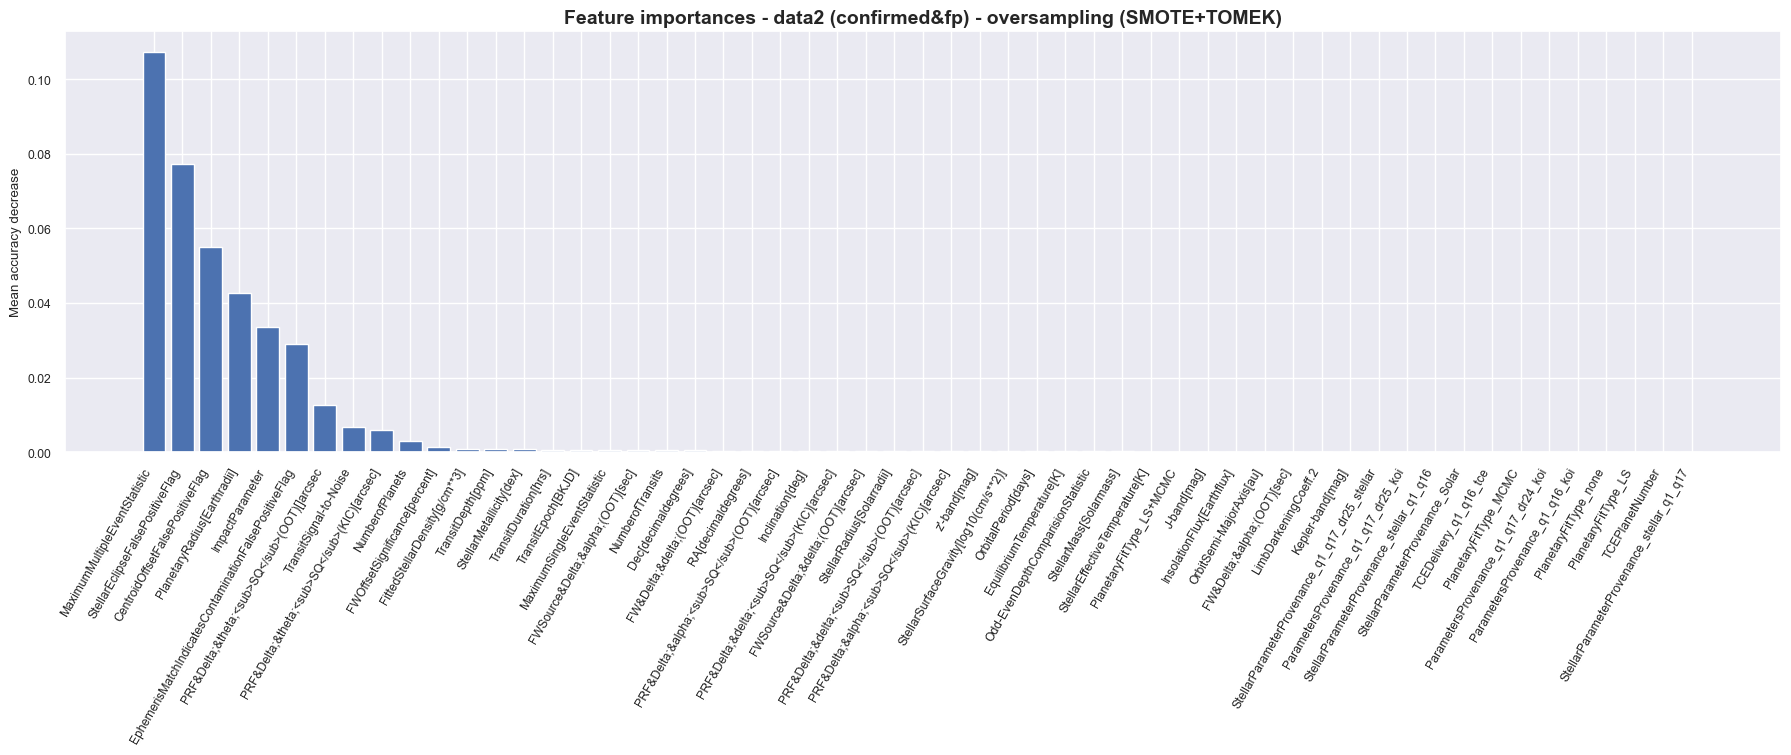

The selected features and their importance:
                                                    Importance
StellarEclipseFalsePositiveFlag                       0.118055
CentroidOffsetFalsePositiveFlag                       0.099554
PlanetaryRadius[Earthradii]                           0.064567
EphemerisMatchIndicatesContaminationFalsePositi...    0.059096
MaximumMultipleEventStatistic                         0.035910
PlanetaryFitType_LS+MCMC                              0.018347
PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec           0.001552
PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec]           0.001014

** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** 
Handling data2 (confirmed&fp) undersampling (CNN+TOMEK)


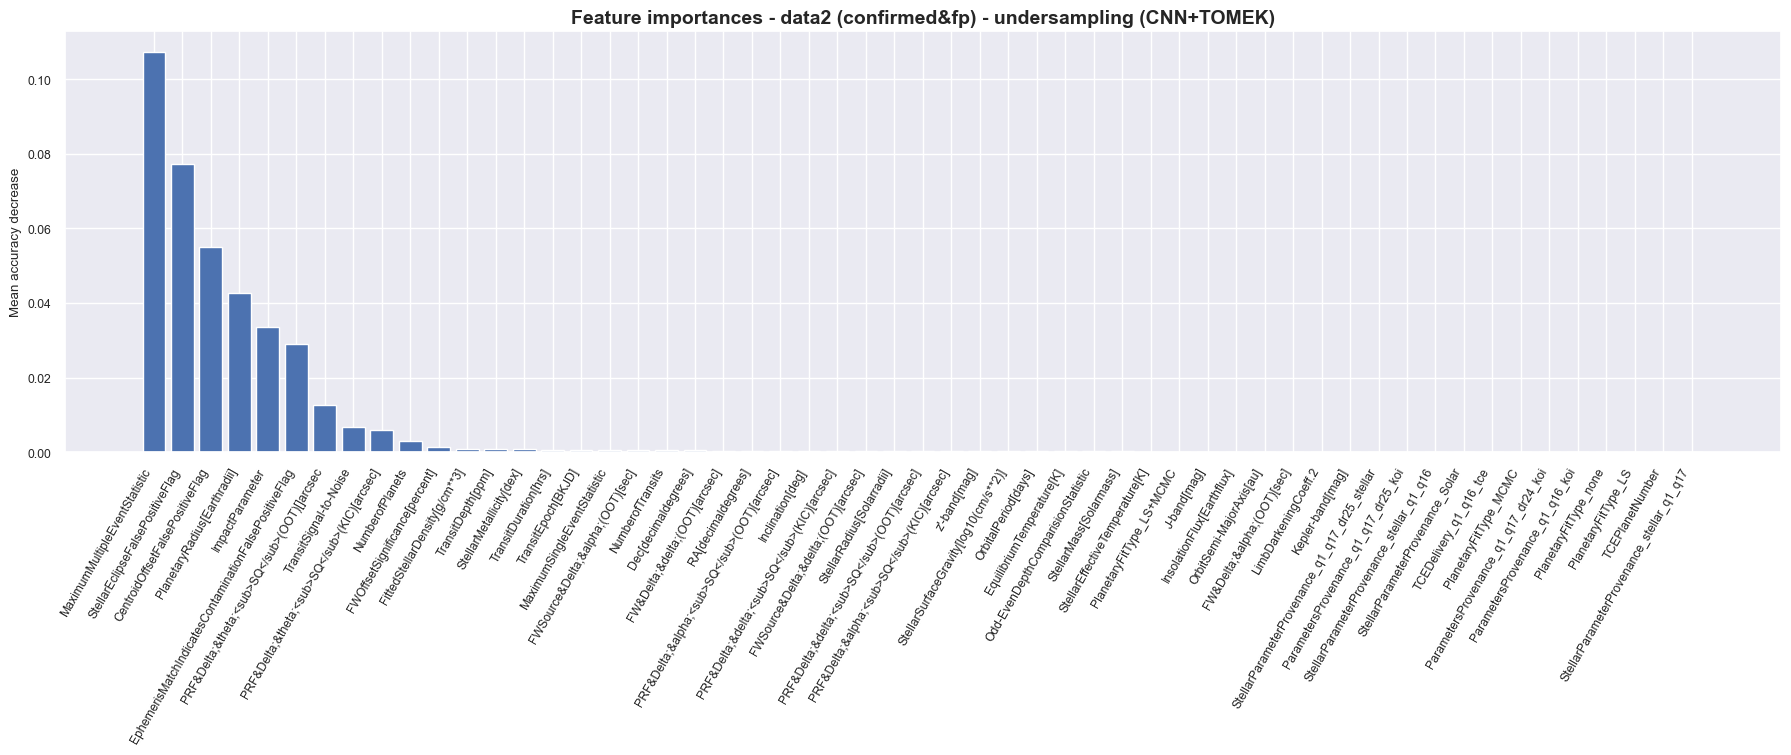

The selected features and their importance:
                                                    Importance
StellarEclipseFalsePositiveFlag                       0.062788
MaximumMultipleEventStatistic                         0.043910
CentroidOffsetFalsePositiveFlag                       0.034533
PlanetaryRadius[Earthradii]                           0.028254
EphemerisMatchIndicatesContaminationFalsePositi...    0.023315
StellarEffectiveTemperature[K]                        0.001591


In [168]:
# run feature selection for data2 (confirmed and false-positives) for both version of oversampled and undersampled

x2_train_os, x2_test_os = feature_selection('data2 (confirmed&fp)', 'oversampling (SMOTE+TOMEK)', 
                                            x2_res_SMOTE, y2_res_SMOTE, x2_test, THRESH)

x2_train_us, x2_test_us = feature_selection('data2 (confirmed&fp)', 'undersampling (CNN+TOMEK)', 
                                            x2_res_cnn, y2_res_cnn, x2_test, THRESH)

### Datasets Summary

As stated above we have 4 datasets that we will test our models on and pick the best on. Below is a summary of these sets.

In [199]:
X1_train_os, y1_train_os, X1_test_os, y1_test_os = x1_train_os, y1_res_SMOTE, x1_test_os, y1_test
X1_train_us, y1_train_us, X1_test_us, y1_test_us = x1_train_us, y1_res_cnn, x1_test_us, y1_test
X2_train_os, y2_train_os, X2_test_os, y2_test_os = x2_train_os, y2_res_SMOTE, x2_test_os, y2_test
X2_train_us, y2_train_us, X2_test_us, y2_test_us = x2_train_us, y2_res_cnn, x2_test_us, y2_test

In [196]:
def check_sizes(dataset, balancing_tec, xtrain, ytrain, xtest, ytest):
    print("\nIn " + dataset + " - " + balancing_tec)
    
    print("\ntrain set shape ", xtrain.shape)
    print("train target shape ", ytrain.shape)
    print("test set shape ", xtest.shape)
    print("test target shape ", ytest.shape)
    
    print("\n overall, " + str(len(ytrain)+len(ytest)) + " samples: ")
    print(" * " + str(len(xtrain)) + " in train")
    print(" * " + str(len(ytest)) + " in test")
    print(" * " + str(xtrain.shape[1]) + " features")
    
    print(" - " * 20)

In [200]:
check_sizes('data1 (all)', 'oversampling (SMOTE+TOMEK)', X1_train_os, y1_train_os, X1_test_os, y1_test_os)
check_sizes('data1 (all)', 'undersampling (CNN+TOMEK)', X1_train_us, y1_train_us, X1_test_us, y1_test_us)
check_sizes('data2 (confirmed & fp)', 'oversampling (SMOTE+TOMEK)', X2_train_os, y2_train_os, X2_test_os, y2_test_os)
check_sizes('data2 (confirmed & fp)', 'undersampling (CNN+TOMEK)', X2_train_us, y2_train_us, X2_test_us, y2_test_us)


In data1 (all) - oversampling (SMOTE+TOMEK)

train set shape  (9754, 11)
train target shape  (9754,)
test set shape  (2300, 11)
test target shape  (2300,)

 overall, 12054 samples: 
 * 9754 in train
 * 2300 in test
 * 11 features
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

In data1 (all) - undersampling (CNN+TOMEK)

train set shape  (2839, 14)
train target shape  (2839,)
test set shape  (2300, 14)
test target shape  (2300,)

 overall, 5139 samples: 
 * 2839 in train
 * 2300 in test
 * 14 features
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

In data2 (confirmed & fp) - oversampling (SMOTE+TOMEK)

train set shape  (6508, 8)
train target shape  (6508,)
test set shape  (1746, 8)
test target shape  (1746,)

 overall, 8254 samples: 
 * 6508 in train
 * 1746 in test
 * 8 features
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

In data2 (confirmed & fp) - undersampling (CNN+TOMEK)

train set shape  (2389, 6)
train target shape  (2389,)
test set

------------------------------------------------------------------------------------------------------

<a id='model-building'></a>

## 5. Model Building
Next, we will build different machine learning models for exoplanet classification. since we are testing 4 different datasets the model training will be done in functions so we can easily call on them with the different sets. The models we are going to train:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machines (SVM)
5. Gradient Boosting

For each model, we will perform the following steps:
1. Initialize the model with default parameters.
2. Train the model on the training data.
3. Evaluate the model's performance using appropriate metrics.
4. Tune the hyperparameters if necessary.
------------------------------------------------------------------------------------------------------

In [208]:
# given the best model, test set (target and values), 
# predict the results of the test set, and calculate the different classification metrics
def get_metrics(xtest, y, best):
    # predict 
    pred = best.predict(xtest)
    # calc metrics
    accuracy = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    roc = roc_auc_score(y, pred)
    f1 = f1_score(y, pred)
    
    return accuracy, precision, recall, roc, f1

In [233]:
# Logistic regression
def eval_logreg(X_train, y_train, X_test, y_test):
    # Grid search for Logistic Regression
    logreg = LogisticRegression(random_state=42, max_iter=1000)

    logreg_params = {
        'C': np.logspace(-3, 3, 7),  # Regularization parameter (inverse of lambda)
        'penalty': ['l1', 'l2'],     # Regularization type (L1 or L2)
        'solver': ['liblinear'],     # Choose the solver for logistic regression
    }

    scoring_metric = make_scorer(roc_auc_score)

    logreg_grid = GridSearchCV(logreg, logreg_params, scoring=scoring_metric, n_jobs=-1)
    logreg_grid.fit(X_train, y_train)
    logreg_best_params = logreg_grid.best_params_
    print("Logisctic Regression best parameters are: ", logreg_best_params)
    logreg_best_model = logreg_grid.best_estimator_ #save the best model
    accuracy, precision, recall, roc, f1 = get_metrics(X_test, y_test, logreg_best_model)

    return [accuracy, precision, recall, roc, f1, logreg_best_model, logreg_best_params]


# Decision Tree
def eval_dt(X_train, y_train, X_test, y_test):
    # Grid search for Decision Trees
    dt = DecisionTreeClassifier()
    dt_params = {
        'max_depth': [None, 5, 10]}
    dt_grid = GridSearchCV(dt, dt_params)
    dt_grid.fit(X_train, y_train)
    dt_best_params = dt_grid.best_params_
    print("Decision Tree Classifier best parameters are: ", dt_best_params)
    dt_best_model = dt_grid.best_estimator_ #save the best model
    accuracy, precision, recall, roc, f1 = get_metrics(X_test, y_test, dt_best_model)

    return [accuracy, precision, recall, roc, f1, dt_best_model, dt_best_params]


#Random forest
def eval_rf(X_train, y_train, X_test, y_test):
    # Grid search for Random Forests
    rf = RandomForestClassifier(n_jobs=-1)
    rf_params = {
        'n_estimators': [20, 50, 60]}
    rf_grid = GridSearchCV(rf, rf_params)
    rf_grid.fit(X_train, y_train)
    rf_best_params = rf_grid.best_params_
    print("Random Forest Classifier best parameters are: ", rf_best_params)
    rf_best_model = rf_grid.best_estimator_ #save the best model
    accuracy, precision, recall, roc, f1 = get_metrics(X_test, y_test, rf_best_model)

    return [accuracy, precision, recall, roc, f1, rf_best_model, rf_best_params]


# SVM
def eval_svm(X_train, y_train, X_test, y_test):
    # Define the parameter grid to search for the best hyperparameters
    param_grid = {
#         'C': [0.1, 1, 10, 40], 
#         'C': [0.1, 1, 5], # Regularization parameter
#         'kernel': ['rbf', 'poly'],        # Kernels to try: RBF and polynomial
#         'degree': [2, 3, 4],              # Degree for the polynomial kernel
#         'gamma': ['scale', 'auto'],       # Kernel coefficient for 'rbf' kernel
    }

    # Create the SVM classifier
    svm = SVC(probability=True)
    # Use GridSearchCV to find the best hyperparameters using cross-validation
    svm_grid = GridSearchCV(svm, param_grid, cv=5)
    svm_grid.fit(X_train, y_train)
    svm_best_params = svm_grid.best_params_
    print("SVM best parameters are: ", svm_best_params)
    svm_best_model = svm_grid.best_estimator_ #save the best model
    accuracy, precision, recall, roc, f1 = get_metrics(X_test, y_test, svm_best_model)

    return [accuracy, precision, recall, roc, f1, svm_best_model, svm_best_params]

In [234]:
def fit_models(dataset, balancing_tec, Xtrain, ytrain, Xtest, ytest):
    #set and fit each model by calling its function
    logreg_res = eval_logreg(Xtrain, ytrain, Xtest, ytest)
    decision_tree_res = eval_dt(Xtrain, ytrain, Xtest, ytest)
    random_forest_res = eval_rf(Xtrain, ytrain, Xtest, ytest)
    svm_res = eval_svm(Xtrain, ytrain, Xtest, ytest)
    
    return [logreg_res, decision_tree_res, random_forest_res, svm_res, dataset, balancing_tec]

In [239]:
data1_os_models = fit_models('data1 (all)', 'oversampling (SMOTE+TOMEK)', 
                             X1_train_os, y1_train_os, X1_test_os, y1_test_os)

Logisctic Regression best parameters are:  {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree Classifier best parameters are:  {'max_depth': 10}
Random Forest Classifier best parameters are:  {'n_estimators': 50}
SVM best parameters are:  {}


In [240]:
data1_us_models = fit_models('data1 (all)', 'undersampling (CNN+TOMEK)', 
                             X1_train_us, y1_train_us, X1_test_us, y1_test_us)

Logisctic Regression best parameters are:  {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree Classifier best parameters are:  {'max_depth': 5}
Random Forest Classifier best parameters are:  {'n_estimators': 50}
SVM best parameters are:  {}


In [241]:
data2_os_models = fit_models('data2 (confirmed & fp)', 'oversampling (SMOTE+TOMEK)', 
                             X2_train_os, y2_train_os, X2_test_os, y2_test_os)

Logisctic Regression best parameters are:  {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree Classifier best parameters are:  {'max_depth': 10}
Random Forest Classifier best parameters are:  {'n_estimators': 50}
SVM best parameters are:  {}


In [235]:
data2_us_models = fit_models('data2 (confirmed & fp)', 'undersampling (CNN+TOMEK)', 
                             X2_train_us, y2_train_us, X2_test_us, y2_test_us)

Logisctic Regression best parameters are:  {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree Classifier best parameters are:  {'max_depth': 10}
Random Forest Classifier best parameters are:  {'n_estimators': 50}
SVM best parameters are:  {}


------------------------------------------------------------------------------------------------------

<a id='model-evaluation'></a>

## 6. Model Evaluation
After building and tuning the models, we will evaluate their performance using various evaluation metrics such as accuracy, precision, recall, and F1-score. We will also visualize the results using confusion matrices and ROC curves.

In [256]:
temp = []
for res in [data1_os_models, data1_us_models, data2_os_models, data2_us_models]:
    for i in range(0, 4):
        temp.append([res[4], res[5]] + res[i])

metrics_df = pd.DataFrame(temp, columns = ['dataset', 'balancing_tec', 'accuracy', 'precision',
                                           'recall', 'roc', 'f1', 'best_model', 'best_param'])
metrics_df.sort_values(by='f1', ascending=False, inplace = True)
metrics_df

,dataset,balancing_tec,accuracy,precision,recall,roc,f1,best_model,best_param
10,data2 (confirmed & fp),oversampling (SMOTE+TOMEK),0.982245,0.983051,0.969605,0.979747,0.976282,"(DecisionTreeClassifier(max_features='sqrt', r...",{'n_estimators': 50}
9,data2 (confirmed & fp),oversampling (SMOTE+TOMEK),0.970790,0.964778,0.957447,0.968154,0.961098,DecisionTreeClassifier(max_depth=10),{'max_depth': 10}
8,data2 (confirmed & fp),oversampling (SMOTE+TOMEK),0.966208,0.937226,0.975684,0.968081,0.956069,"LogisticRegression(C=1000.0, max_iter=1000, pe...","{'C': 1000.0, 'penalty': 'l1', 'solver': 'libl..."
14,data2 (confirmed & fp),undersampling (CNN+TOMEK),0.964490,0.931884,0.977204,0.967003,0.954006,"(DecisionTreeClassifier(max_features='sqrt', r...",{'n_estimators': 50}
13,data2 (confirmed & fp),undersampling (CNN+TOMEK),0.954754,0.910638,0.975684,0.958890,0.942040,DecisionTreeClassifier(max_depth=10),{'max_depth': 10}
11,data2 (confirmed & fp),oversampling (SMOTE+TOMEK),0.949599,0.900281,0.974164,0.954453,0.935766,SVC(probability=True),{}
6,data1 (all),undersampling (CNN+TOMEK),0.941739,0.885174,0.917169,0.934440,0.900888,"(DecisionTreeClassifier(max_features='sqrt', r...",{'n_estimators': 50}
2,data1 (all),oversampling (SMOTE+TOMEK),0.940000,0.890208,0.903614,0.929191,0.896861,"(DecisionTreeClassifier(max_features='sqrt', r...",{'n_estimators': 50}
12,data2 (confirmed & fp),undersampling (CNN+TOMEK),0.901489,0.795620,0.993921,0.919755,0.883784,"LogisticRegression(C=1000.0, max_iter=1000, pe...","{'C': 1000.0, 'penalty': 'l1', 'solver': 'libl..."
1,data1 (all),oversampling (SMOTE+TOMEK),0.924783,0.832206,0.926205,0.925205,0.876693,DecisionTreeClassifier(max_depth=10),{'max_depth': 10}


In [242]:
def get_res(results, i):
    # given the results list and the index of the wanted result return it for all the different models
    return [results[0][i], results[1][i], results[2][i], results[3][i]]

def plot_metrics(results, Xtest, ytest):
    models = get_res(results, 5)
    # List of model names for plotting
    model_names = ['LogReg', 'DT', 'RF', 'SVM']
    # Create separate ROC curve plots for 'models_os'
    plt.figure()
    for i, model in enumerate(models):
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(Xtest)[:, 1]
        else:
            y_pred = model.decision_function(Xtest)  # Use decision_function for SVM
        fpr, tpr, _ = roc_curve(ytest, y_pred)
        auc = roc_auc_score(ytest, y_pred)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_names[i], auc))

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal (random classifier)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - ' + results[4] + ' - ' + results[5], fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.show()
    
    # draw the metrics in a bar chart
    # Evaluation results for each model
    accuracy, precision, recall, f1 = get_res(results, 0), get_res(results, 1), get_res(results, 2), get_res(results, 4)

    # Define the positions of the bars on the x-axis
    x = np.arange(len(model_names))

    # Set the width of each bar and the separation between models
    bar_width = 0.2
    bar_separation = 0.1

    # Create the bar plot for each metric
    plt.bar(x - 2*bar_width - bar_separation, accuracy, width=bar_width, label='Accuracy', color='green', edgecolor='black')
    plt.bar(x - bar_width - bar_separation, precision, width=bar_width, label='Precision', color='blue', edgecolor='black')
    plt.bar(x - bar_separation, recall, width=bar_width, label='Recall', color='red', edgecolor='black')
    plt.bar(x + bar_width - bar_separation, f1, width=bar_width, label='F1', color='yellow', edgecolor='black')

    plt.xlabel('Models') # Add x-axis labels
    plt.ylabel('Scores')
    plt.title('Evaluation Results') # Add y-axis label
    plt.xticks(x - bar_width / 2 - bar_separation, model_names) # Add x-axis tick labels
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4) # Add a legend

    # Display the plot
    plt.show()

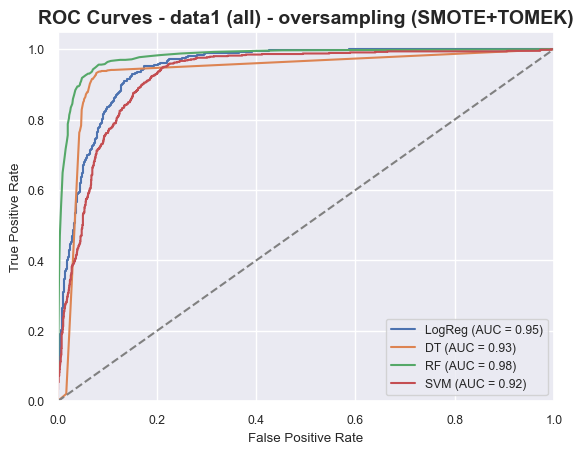

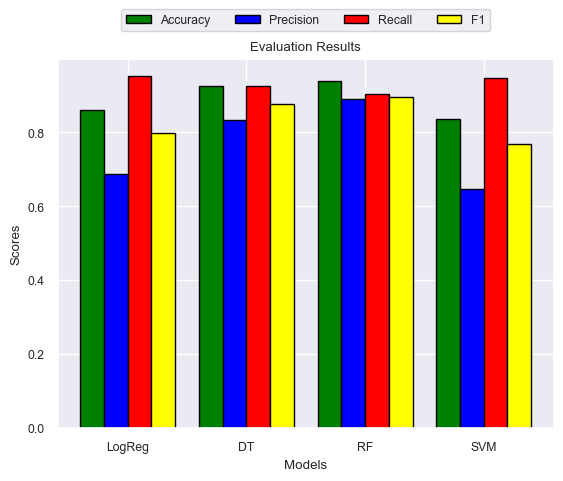

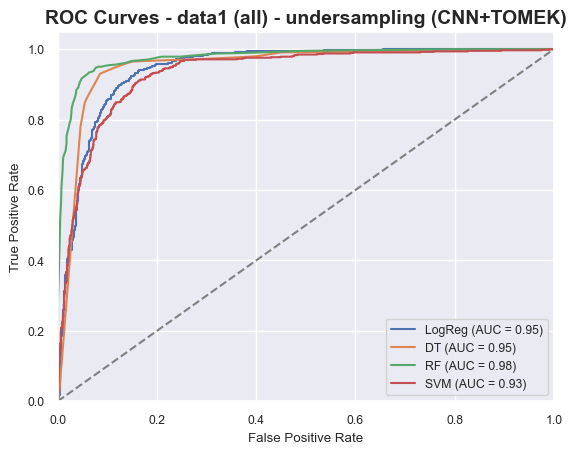

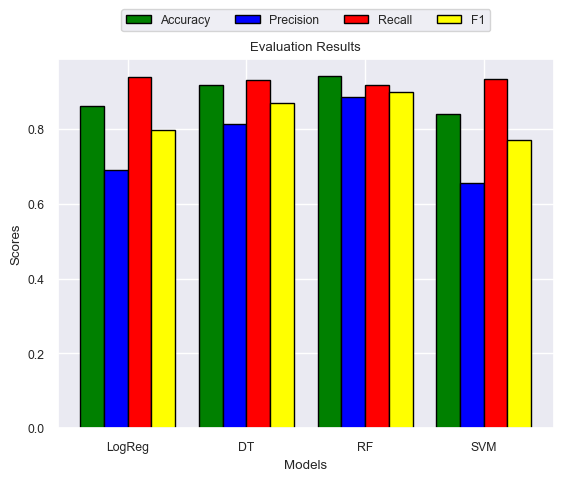

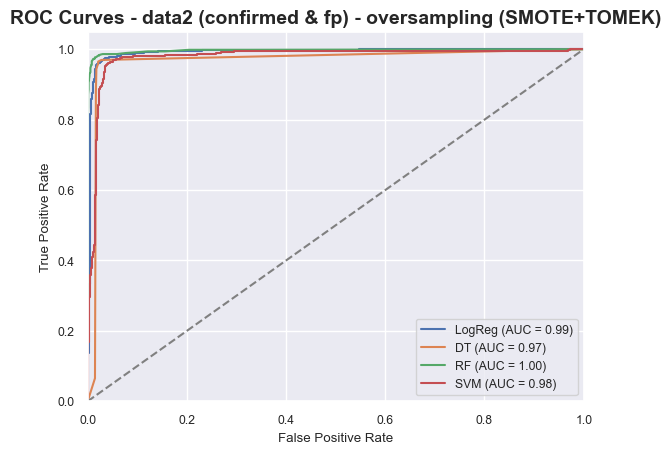

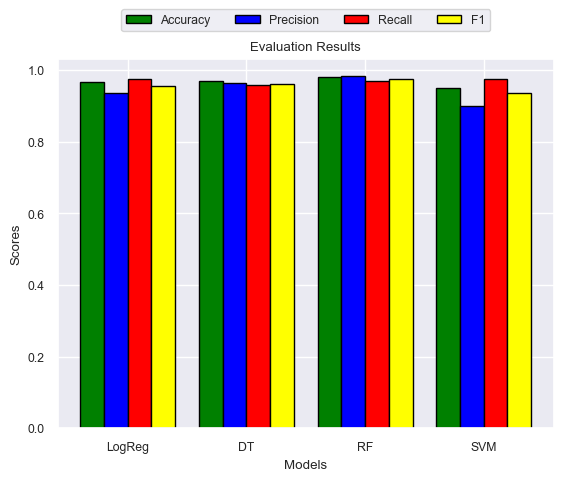

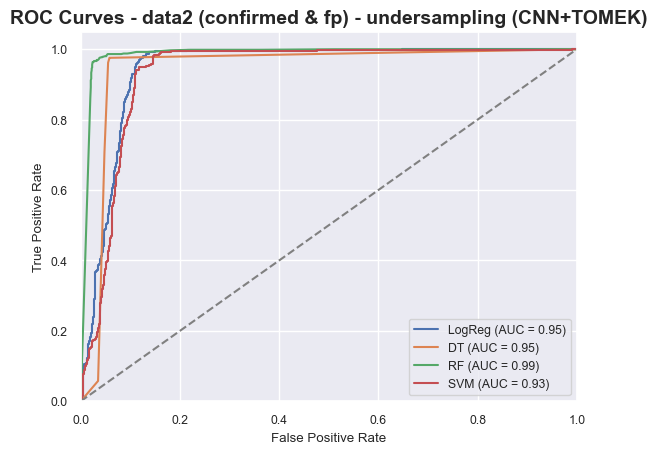

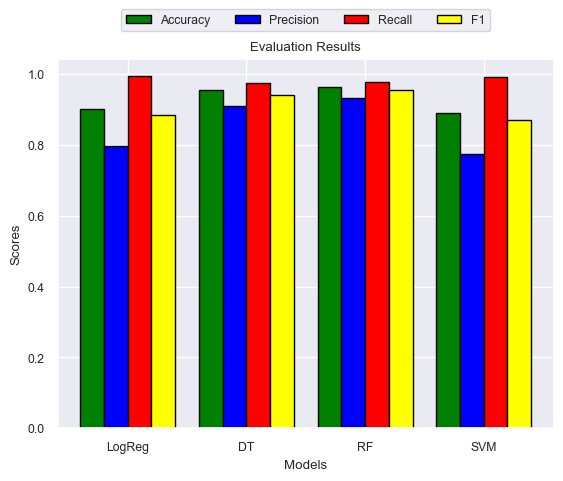

In [243]:
#plot roc curve and barplot for metrics for all model results
plot_metrics(data1_os_models, X1_test_os, y1_test_os)

plot_metrics(data1_us_models, X1_test_us, y1_test_us)

plot_metrics(data2_os_models, X2_test_os, y2_test_os)

plot_metrics(data2_us_models, X2_test_us, y2_test_us)

We can see that our **SMOTE+Tomak** models performed better than the **CNN+Tomak** ones, so we will be using only them onwards.

### We can observe than our best model for classification is the **Random Forest** trained on the **SMOTE+TOMEK** oversampled dataset.

------------------------------------------------------------------------------------------------------

<a id='conclusion'></a>

## 7. Conclusion

In conclusion, this project aims to classify exoplanets using machine learning techniques. By exploring the dataset, preprocessing the data, building and evaluating different models, we will gain insights into the classification of exoplanets and identify the most accurate model for exoplanet classification.

------------------------------------------------------------------------------------------------------

<a id='references'></a>

## 8. References

1. [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html)
2. Insert other references or resources used during the project.